In [1]:
# These are the libraries and packages we are going to need for sure:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import demux_kadir as demux
import nurk as nurk
from nurk import resolution_lines, pos_resolution
import numba as nb
from numba import jit, njit
from numba import cuda

import time
import multiprocessing
import os
import sys

BUILD_DIR = 'build/'
if not os.path.exists(BUILD_DIR):
    os.makedirs(BUILD_DIR)

In [2]:
colis = [i for i in range(0,6)]

In [3]:
with open('output_data.pkl', 'rb') as f:
    event_points_all_df0 = pickle.load(f)


In [4]:
# Loading multiple objects example
event_points_all = []
with open('output_data.pkl', 'rb') as f:
    while True:
        try:
            event_points_all.append(pickle.load(f))
        except EOFError:
            break

# Unpack the loaded objects if needed
if len(event_points_all) >= 4:
    event_points_all_df0, event_points_all_df1, event_points_all_df2, event_points_all_df3 = event_points_all[:4]
else:
    print("Not enough objects were loaded.")

Not enough objects were loaded.


In [5]:
#with open('output_data.pkl', 'rb') as f:
#    event_points_all_df = pickle.load(f)
#event_points_all_df=event_points_all_df0
with open('output_data.pkl', 'rb') as f:
    event_points_all_df2 = pickle.load(f)

In [4]:
import math

def average_scattering_angle(material, thickness_cm, momentum_GeV):
    # Radiation lengths for different materials in cm
    radiation_lengths = {
        'lead': 0.56,
        'water': 36.1,
        'iron': 1.76,
        'cobalt': 2,  # approximate value
        'copper': 1.43,
        'zinc': 3.56
    }

    # Select radiation length based on the material
    X0 = radiation_lengths.get(material.lower(), None)
    if X0 is None:
        return "Material not found in the database"

    # Convert thickness from cm to meters
    thickness_m = thickness_cm / 100.0

    # Calculate the scattering angle
    beta = 1.0  # relativistic muon
    p = momentum_GeV * 1000.0  # convert GeV to MeV
    z = 1  # muon charge
    theta_0 = (13.6 / (beta * p)) * z * math.sqrt(thickness_m / X0) * (1 + 0.038 * math.log(thickness_m / X0))

    # Convert radians to milliradians
    theta_mrad = theta_0 * 1000.0

    return theta_mrad

# Example usage
material = 'lead'
thickness_cm = 1  # in cm
momentum_GeV = 1  # in GeV
result = average_scattering_angle(material, thickness_cm, momentum_GeV)
print(f"Average scattering angle for a {thickness_cm} cm cube of {material}: {result:.2f} milliradians")

Average scattering angle for a 1 cm cube of lead: 1.54 milliradians


In [5]:
# event_points_all_df1=event_points_all_df
# with open('output_data.pkl', 'wb') as f:
#     pickle.dump((event_points_all_df1), f)

In [41]:
with open('output_data.pkl', 'wb') as f:
    pickle.dump((event_points_all_df), f)

Input file

In [7]:
files = ['new_limits_march_8_2024_1x_900s_0_0_singles']

In [8]:
# parameters
offset = 0.

flag = ''

nrows = 500000

In [9]:
if nrows != 'all':
    try:
        adf = pd.read_csv(files[0] + '.dat.gz', compression='gzip', sep='\t', header = None, nrows = nrows)
    except ValueError:
        adf = pd.read_csv(files[0] + '.dat.gz', compression='gzip', sep='\t', header = None, skiprows = 1, nrows = nrows)
else:
    try:
        adf = pd.read_csv(files[0] + '.dat.gz', compression='gzip', sep='\t', header = 0)
    except ValueError:
        adf = pd.read_csv(files[0] + '.dat.gz', compression='gzip', sep='\t', header = 0, skiprows = 1)
time_e = (adf.iloc[-1,0] - adf.iloc[0,0])/1000000000000.

del adf

In [10]:
print("Time to process: ", time_e)

Time to process:  1.56839273568


Limits identifier (part of the name after common parts)

In [11]:
limits_id = files[0]
#limits_id = 'Pb3_X_65_85_Y24_45_single'

Print out function

In [12]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

Excel reading

In [13]:
#mux_chans_xlsx = pd.read_excel("Alara_Mapping_new_old.xlsx", sheet_name = "Mapping for ALARA plate")

#mux_chans_xlsx = pd.read_excel("Alara_Mapping_2.xlsx", sheet_name = "Mapping for ALARA plate 02")
#mux_chans_xlsx = pd.read_excel("Alara_Mapping_3.xlsx", sheet_name = "Mapping for ALARA plate 02port8")
#mux_chans_xlsx = pd.read_excel("Alara_Mapping_4.xlsx", sheet_name = "Mapping for ALARA plate 02port8")
mux_chans_xlsx = pd.read_excel("etc/Alara_Mapping_6.xlsx", sheet_name = "Mapping ALARA H2V3")
#sheet_lab = " Tomograph "
#map_file = "C:\\Users\\michal.deak\\Nextcloud\\Gscan\\Tech\\Prototype measurement results\\Tomograph (MVP2)\\Tomograph_mapping.xlsx"
#mux_chans_xlsx = pd.read_excel(map_file, sheet_name = "H4" + sheet_lab + "DOWN")

Mapping reading

In [14]:
mux_chans = mux_chans_xlsx.iloc[11:27,1:67]

In [15]:
mux_chans.iloc[:,2:67] = mux_chans.iloc[:,2:67].astype(dtype = 'int')

In [16]:
colums = []
for j in range(0,16,2):
    colums.append([str(j) + "_" + str(i) for i in range(1,5)] + [str(j + 1) + "_" + str(i) for i in range(5,9)])

In [17]:
mux_chans.columns = ['MUX','XY+-'] + list(np.array(colums).flatten())

In [18]:
mux_chans.reset_index(drop = True, inplace = True)

In [19]:
mux_chans_list = list(np.array(mux_chans[list(np.array(colums).flatten())]).flatten())

In [20]:
mux_chans['MUX'] = mux_chans['MUX'].astype(dtype = 'int')

In [21]:
mux_chans_p = pd.pivot_table(mux_chans, columns = ['MUX','XY+-'], values = list(np.array(colums).flatten()))

In [22]:
mux_chans.to_csv("mux_channels_alara.csv", sep = ";")

In [23]:
chans_to_ASIC = mux_chans.iloc[:,2:].melt()
chans_to_ASIC.columns = ['ASIC','channel']

Table of mats

In [24]:
mats_table = mux_chans_xlsx.iloc[np.r_[48:50,51:53,54:56],40:52].reset_index(drop = True)

Table of ASIC_sockets

In [25]:
asics_table = mux_chans_xlsx.iloc[np.r_[31:33,34:36,37:39],5:17].reset_index(drop = True)

Table of MUX board positions

In [26]:
muxs_table = mux_chans_xlsx.iloc[np.r_[48:50,51:53,54:56],5:17].reset_index(drop = True)

In [27]:
short_mats_table = mats_table.iloc[::2,:6].reset_index(drop = True)
long_mats_table = mats_table.iloc[1::2,:12].reset_index(drop = True)

In [28]:
short_asics_table = asics_table.iloc[::2,:6].reset_index(drop = True)
long_asics_table = asics_table.iloc[1::2,:12].reset_index(drop = True)

In [29]:
short_muxs_table = muxs_table.iloc[::2,:6].reset_index(drop = True)
long_muxs_table = muxs_table.iloc[1::2,:12].reset_index(drop = True)

In [30]:
asics_list = list(np.array(short_asics_table).flatten()) + list(np.array(long_asics_table).flatten())
mats_list = list(np.array(short_mats_table).flatten()) + list(np.array(long_mats_table).flatten())
muxs_list = list(np.array(short_muxs_table).flatten()) + list(np.array(long_muxs_table).flatten())

short_label = ['short']*len(list(np.array(short_asics_table).flatten()))
long_label = ['long']*len(list(np.array(long_asics_table).flatten()))
l_label = short_label + long_label

In [31]:
asics_list

['12,1',
 '12,2',
 '12,3',
 '12,4',
 '13,5',
 '13,6',
 '10,1',
 '10,2',
 '10,3',
 '10,4',
 '11,5',
 '11,6',
 '8,1',
 '8,2',
 '8,3',
 '8,4',
 '9,5',
 '9,6',
 '14,3',
 '14,4',
 '2,1',
 '2,2',
 '2,3',
 '2,4',
 '3,5',
 '3,6',
 '3,7',
 '3,8',
 '0,1',
 '0,2',
 '15,5',
 '15,6',
 '4,1',
 '4,2',
 '4,3',
 '4,4',
 '5,5',
 '5,6',
 '5,7',
 '5,8',
 '0,3',
 '0,4',
 '15,7',
 '15,8',
 '6,1',
 '6,2',
 '6,3',
 '6,4',
 '7,5',
 '7,6',
 '7,7',
 '7,8',
 '1,5',
 '1,6']

In [32]:
def layer(x):
    if x[1] == 'short':
        if x[0] < 6:
            return 0
        elif x[0] < 24:
            return 2
        elif x[0] < 42:
            return 4
    elif x[1] == 'long':
        if x[0] < 18:
            return 1
        elif x[0] < 36:
            return 3
        elif x[0] < 54:
            return 5

In [33]:
mats_asics_df = pd.DataFrame(columns = ['ASIC','mat'])
mats_asics_df['ASIC'] = asics_list
mats_asics_df['mat'] = mats_list
mats_asics_df['MUX'] = muxs_list
mats_asics_df['length'] = l_label
mats_asics_df['layer'] = mats_asics_df[['MUX','length']].apply(layer, axis = 1)

C:\Users\sanna.kruusmaa\AppData\Local\Temp\ipykernel_14648\3667995498.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1] == 'short':
C:\Users\sanna.kruusmaa\AppData\Local\Temp\ipykernel_14648\3667995498.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[0] < 6:
C:\Users\sanna.kruusmaa\AppData\Local\Temp\ipykernel_14648\3667995498.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif x[0] < 24:
C:\Users\sanna.kruusm

In [34]:
mats_asics_df['ASIC'] = mats_asics_df['ASIC'].apply(lambda x: x.replace(",","_"))

In [35]:
val_dict = []
for chan in list(mux_chans.iloc[:,2:66].melt()['value']):
    asic_socket = chans_to_ASIC[chans_to_ASIC['channel'] == chan]['ASIC'].iloc[0]

    MX = list(mux_chans[mux_chans[asic_socket] == chan][['MUX','XY+-']].iloc[0])
    
    val_dict.append((chan,MX))

In [36]:
val_dict = dict(val_dict)

Mapping for demuxing

In [37]:
work_df = mats_asics_df.copy()

In [38]:
ch_to_A_df = chans_to_ASIC.copy()

In [39]:
ch_to_A_df['scheme'] = np.array([[1]*4 + [2]*4 + [3]*4 + [4]*4 for i in range(0,64)]).flatten()
ch_to_A_df['X+-'] = np.array([['xp','xm','yp','ym'] for i in range(0,256)]).flatten()

In [40]:
ch_to_A_df['asic'] = ch_to_A_df['ASIC'].apply(lambda x: int(x.split("_")[0]))
ch_to_A_df['jack'] = ch_to_A_df['ASIC'].apply(lambda x: int(x.split("_")[1]))
ch_to_A_df.drop(columns = ['ASIC'], inplace = True)

In [41]:
work_df.drop(columns = ['length','mat','layer'], inplace = True)
work_df.rename(columns = {'MUX':'plate'}, inplace = True)
work_df['asic'] = work_df['ASIC'].apply(lambda x: int(x.split("_")[0]))
work_df['jack'] = work_df['ASIC'].apply(lambda x: int(x.split("_")[1]))
work_df['plate'] = work_df['plate']
work_df.drop(columns = ['ASIC'], inplace = True)

In [42]:
merged_df = work_df.merge(ch_to_A_df, on = ['asic','jack'])

*If mapping modified, output file best changed here and also (as input file) in the demuxing function*

In [43]:
merged_df.pivot_table(index = ['plate','scheme','asic','jack'], \
columns = ['X+-']).reset_index().to_csv("temp.muxmap.csv", sep = ",", header = ['plate','scheme','asic','jack','xm','xp','ym','yp'], index = False)

Vector functions

In [44]:
def angle(v1, v2):
    np.seterr(all='raise')
    
    v1s = np.sqrt(np.dot(v1, v1))
    v2s = np.sqrt(np.dot(v2, v2))
    
    v1 /= v1s
    v2 /= v2s
    
    dotprod = np.dot(v1, v2)
    
    if dotprod > 1.:
        return 0.
    else:
        return np.arccos(dotprod)

In [45]:
def vect_norm(v):
    return v/np.sqrt(np.dot(v,v))

Demuxing

In [45]:
# input: input file, output file (given by dat file), mapping file and optional nrows (number of rows; default = 'all')
# if nrows left out or nrows = 'all', the whole dat file is processed
demux.demux_func(files[0] + '.dat', 'out_' + files[0] + '_h3.csv', 'h3.muxmap.csv', nrows = nrows)

Reading the data from input file took =  0  seconds
Number of rows in the input file =  500000
Sorting the initial data took =  0  seconds
Converting time to event_id took =  0  seconds
Number of events detected =  293331
[  34    4    0    3  139    2 4096    3]
[[7.06767388e+12 7.34028000e-01 8.54400000e+03]
 [7.06767495e+12 3.14301000e-01 4.21600000e+03]
 [7.06769673e+12 3.75397000e-01 4.77800000e+03]
 [7.06770422e+12 3.13610000e-01 4.87000000e+03]
 [7.06770706e+12 5.63751000e-01 1.30360000e+04]
 [7.06771627e+12 3.87135000e-01 5.42000000e+02]
 [7.06772982e+12 5.90677000e-01 1.30310000e+04]
 [7.06772982e+12 5.57064000e-01 1.30290000e+04]
 [7.06773128e+12 5.13340000e-01 4.22200000e+03]
 [7.06773685e+12 7.90596000e-01 1.25310000e+04]]
0.0 13183.0
[4096 4097 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109
 4110 4111 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123
 4124 4125 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137
 4138 4139 4140 4141 4142 4143

FileNotFoundError: [Errno 2] No such file or directory: 'build//new_limits_march_8_2024_1x_900s_0_0_singles.limits_x.csv'

In [121]:
demux_out_df = pd.read_csv('new_limits_march_8_2024_1x_900s_0_0_singles_3.out.csv', sep = ';', header = None)
#demux_out_df = pd.read_csv('out_' + files[0] + '.csv', sep = ';', header = None)

Geometry

In [122]:
mux_start_dict = {1:2,2:4,3:1,4:3}
lay_d = 2.
pos_mux_dict = {0:200., 1:200. - lay_d, 2:100., 3:100. - lay_d, 4:0., 5:0. - lay_d}
plate_mat_dict = {0: 0,1: 0,2: 0,3: 0,4: 0,5: 0,6: 1,7: 1,8: 1,9: 1,10: 1,11: 1,12: 1,13: 1,14: 1,15: 1,16: 1,17: 1,18: 2,19: 2,20: 2,21: 2,22: 2,23: 2,24: 3,25: 3,26: 3,27: 3,28: 3,29: 3,30: 3,31: 3,32: 3,33: 3,34: 3,35: 3,36: 4,37: 4,38: 4,39: 4,40: 4,41: 4,42: 5,43: 5,44: 5,45: 5,46: 5,47: 5,48: 5,49: 5,50: 5,51: 5,52: 5,53: 5}
ver_shift = 0.74833

In [123]:
posx = []
posy = []
for fiber in range(1,13825):
    mux_pl = int((fiber-1)//256)
    if 0 <= mux_pl and mux_pl <= 5:
        x = (fiber - 2)/2.
        gpm = pos_mux_dict[0]
        y = gpm - (1 - fiber%2)*ver_shift
    if 6 <= mux_pl and mux_pl <= 17:
        x = (fiber - 6*256 - 2)/2.
        gpm = pos_mux_dict[1]
        m=(1 - fiber%2)
        n=gpm - (1 - fiber%2)*ver_shift
        y = gpm - (1 - fiber%2)*ver_shift
    if 18 <= mux_pl and mux_pl <= 23:
        x = (fiber - 18*256 - 2)/2.
        gpm = pos_mux_dict[2]
        y = gpm - (1 - fiber%2)*ver_shift
    if 24 <= mux_pl and mux_pl <= 35:
        x = (fiber - 24*256 - 2)/2.
        gpm = pos_mux_dict[3]
        y = gpm - (1 - fiber%2)*ver_shift
    if 36 <= mux_pl and mux_pl <= 41:
        x = (fiber - 36*256 - 2)/2.
        gpm = pos_mux_dict[4]
        y = gpm - (1 - fiber%2)*ver_shift
    if 42 <= mux_pl and mux_pl <= 53:
        x = (fiber - 42*256 - 2)/2.
        gpm = pos_mux_dict[5]
        y = gpm - (1 - fiber%2)*ver_shift
    
    posx.append(x)
    posy.append(y)
print(posy)

[200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 199.25167, 200.0, 19

In [124]:
fibers = range(1,54*256 + 1)
posx_df = pd.Series(list(zip(fibers,posx)))
posy_df = pd.Series(list(zip(fibers,posy)))
posx_df.to_csv("positionsx.csv",sep = ";")
posy_df.to_csv("positionsy.csv",sep = ";")
posx_df = pd.read_csv("positionsx.csv",sep = ";", index_col = None, header = None).iloc[1:,1:]
posy_df = pd.read_csv("positionsy.csv",sep = ";", index_col = None, header = None).iloc[1:,1:]
#print(list(pos_df.iloc[:,0]))
positionsx = dict([eval(x) for x in list(posx_df.iloc[:,0])])
positionsy = dict([eval(x) for x in list(posy_df.iloc[:,0])])

#print(positionsx)
print(positionsy)

{1: 200.0, 2: 199.25167, 3: 200.0, 4: 199.25167, 5: 200.0, 6: 199.25167, 7: 200.0, 8: 199.25167, 9: 200.0, 10: 199.25167, 11: 200.0, 12: 199.25167, 13: 200.0, 14: 199.25167, 15: 200.0, 16: 199.25167, 17: 200.0, 18: 199.25167, 19: 200.0, 20: 199.25167, 21: 200.0, 22: 199.25167, 23: 200.0, 24: 199.25167, 25: 200.0, 26: 199.25167, 27: 200.0, 28: 199.25167, 29: 200.0, 30: 199.25167, 31: 200.0, 32: 199.25167, 33: 200.0, 34: 199.25167, 35: 200.0, 36: 199.25167, 37: 200.0, 38: 199.25167, 39: 200.0, 40: 199.25167, 41: 200.0, 42: 199.25167, 43: 200.0, 44: 199.25167, 45: 200.0, 46: 199.25167, 47: 200.0, 48: 199.25167, 49: 200.0, 50: 199.25167, 51: 200.0, 52: 199.25167, 53: 200.0, 54: 199.25167, 55: 200.0, 56: 199.25167, 57: 200.0, 58: 199.25167, 59: 200.0, 60: 199.25167, 61: 200.0, 62: 199.25167, 63: 200.0, 64: 199.25167, 65: 200.0, 66: 199.25167, 67: 200.0, 68: 199.25167, 69: 200.0, 70: 199.25167, 71: 200.0, 72: 199.25167, 73: 200.0, 74: 199.25167, 75: 200.0, 76: 199.25167, 77: 200.0, 78: 199.2

In [125]:
demux_out_df['mats'] = demux_out_df.iloc[:,1].apply(lambda x: [plate_mat_dict[int((float(u) - 1)//256)] for u in x.split(",")])
demux_out_df['x'] = demux_out_df.iloc[:,1].apply(lambda x: [positionsx[int(float(u))] for u in x.split(",")])
demux_out_df['y'] = demux_out_df.iloc[:,1].apply(lambda x: [positionsy[int(float(u))] for u in x.split(",")])

In [126]:
mux_raw_df = demux_out_df.iloc[:,[0,2,3,4]]

In [127]:
events_l = []
mats_l = []
pointsx_l = []
pointsy_l = []
for io in range(0,mux_raw_df.shape[0]):
    events_l += [mux_raw_df.iloc[io,0]]*len(mux_raw_df.iloc[io,1])
    mats_l += mux_raw_df.iloc[io,1]
    pointsx_l += mux_raw_df.iloc[io,2]
    pointsy_l += mux_raw_df.iloc[io,3]
    
    #print(type(pointsx_l[0]))
    
mux_events_df = pd.DataFrame(list(zip(events_l,mats_l,pointsx_l, pointsy_l)), columns = ['time adjecent', 'fiber mat', 'x','y'])

Clustering

In [128]:
from sklearn.cluster import DBSCAN

In [129]:
new_events = mux_events_df['time adjecent'].unique()

In [130]:
max_dist = 1.118034

In [131]:
#@nb.njit(target='cuda')
@jit(nopython=True)
def dist(p1,p2):
    d = p2 - p1
    return np.sqrt(np.dot(d,d))

In [132]:
#@nb.njit(target='cuda')
#@jit(nopython=True)
def clusts_list(x,y):
    
    #.sort_values(by = [1,0])
    #print(x_df)
    meansx = [x[0]]
    #print(meansx)
    meansy = [y[0]]
    #print(meansy)
    count = 1
    pos = 0
    #print(x,y)
    for i in range(1,x.shape[0]):
        d = dist(np.array([x[i - 1],y[i - 1]]),np.array([x[i],y[i]]))
        if d > max_dist:
            meansx[pos] /= count
            meansy[pos] /= count
            meansx += [0.]
            meansy += [0.]
            pos += 1
            count = 1
        else:
            count += 1
        
        meansx[pos] += x[i]
        meansy[pos] += y[i]
    
    meansx[pos] /= count
    meansy[pos] /= count

    means = np.array(list(zip(meansx[:pos+1], meansy[:pos+1])))
    
    return means

In [133]:
#@nb.njit(target='cuda')
#@jit(nopython=True)
def points_list(x, y):
    meansx = [x[0]]
    meansy = [y[0]]
    pos = 1  # Initialize position index
    for i in range(1, len(x)):
        d = dist(np.array([x[i - 1], y[i - 1]]), np.array([x[i], y[i]]))
        
        if d > max_dist:
            continue

        meansx.append(x[i])
        meansy.append(y[i])
    means = np.array(list(zip(meansx, meansy)))
    return means


In [134]:
event_points_all = []
mats = [0,1,2,3,4,5]
mux_events_ar =  np.array(mux_events_df)
pos = 0
length = mux_events_ar.shape[0]
for event in new_events:
    if event%10000 == 0: print(event)
    points_mat = []
    while mux_events_ar[pos,0] == event:
        points_mat.append(mux_events_ar[pos,:])
        pos += 1
        if pos == length: break
    #kõikidel mattidel eventid mis on samal ajal toimunud
    points_mat = np.array(points_mat)
    matts = np.unique(points_mat[:,1])
    if len(matts) == 6:
        points = []
        mux_boards = []

        for matt in mats:

            #eventide koordinaadid mis on ühel ja samal matil toimunud
            points_mat_event = points_mat[np.where(points_mat[:,1] == matt)][:,[2,3]]
            
            x_df = points_mat_event[np.lexsort((points_mat_event[:,0], points_mat_event[:,1]))][::-1]
            points_lists=points_list(x_df[:,0],x_df[:,1])
            #print(points_lists)
            #all points that go through the conditions are added to the points list
            #all points(cluster) added by mat nr
            points.append(points_lists)
        if len(points) == 6:
            #Kõik matid käiakse läbi ja lisatakse iga eventi kohta punktid järjendisse
            event_points_all.append([event] + points)

798420734320000
831081615040000


In [135]:
event_points = []
#print(events_df.groupby(by = 'time adjecent')['fiber mat lowest'].nunique().max())
#mats = ['B5','B9','B10','J1','J2','J3','J4']
mats = [0,1,2,3,4,5]
mux_events_ar =  np.array(mux_events_df)
events_new=[]
#print(mux_events_df)
#print(len(new_events))
pos = 0
length = mux_events_ar.shape[0]
for event in new_events:
    if event%10000 == 0: print(event)
    ###########################################################
    #points_mat_df = mux_events_df[mux_events_df['time adjecent'] == event]
    #points_mat = mux_events_ar[np.where(mux_events_ar[:,0] == event)]
    points_mat = []
    while mux_events_ar[pos,0] == event:
        points_mat.append(mux_events_ar[pos,:])
        pos += 1
        if pos == length: break
    #kõikidel mattidel eventid mis on samal ajal toimunud
    points_mat = np.array(points_mat)
    matts = np.unique(points_mat[:,1])
    if len(matts) == 6:
        points = []
        mux_boards = []

        for matt in mats:
            #points_mat_event_df = points_mat_df[points_mat_df['fiber mat'] == matt][['x','y']]
            #points_mat_event = np.array(points_mat_df[points_mat_df['fiber mat'] == matt][['x','y']])

            #eventide koordinaadid mis on ühel ja samal matil toimunud
            points_mat_event = points_mat[np.where(points_mat[:,1] == matt)][:,[2,3]]
            
            x_df = points_mat_event[np.lexsort((points_mat_event[:,0], points_mat_event[:,1]))][::-1]
            #points_lists=points_list(x_df[:,0],x_df[:,1])
            #print(points_lists)
            cluster_list = list(clusts_list(x_df[:,1],x_df[:,0]))
            #all points that go through the conditions are added to the points list
            #all points(cluster) added by mat nr
            points.append(cluster_list)
        if len(points) == 6:
            event_points.append([event] + points)


798420734320000
831081615040000


In [136]:
#835571969710000
889058018700000
def mux_pos(x):
    return mats_asics_df[mats_asics_df['ASIC'] == x]['MUX'].iloc[0]

In [137]:
def mux_space(x):
    if x < 6:
        return x
    elif x < 18:
        return x - 6
    elif x < 24:
        return x - 18
    elif x < 36:
        return x - 24
    elif x < 42:
        return x - 36
    else:
        return x - 42

In [138]:
def new_points(x):
    return np.array([ 0.5*(x[0][0] + x[1][0]), x[0][1], x[1][1]])

In [139]:
def flip(x):
    return np.array([x[0],128.*12 -1 - x[1]])

Angle functions

In [140]:
def find_angle_resolution_inc(x):
    
    new_line1,new_line2,new_line3,new_line4= nurk.resolution_lines(x)
    xz_angle_res=nurk.find_angle_between_lines(new_line1, new_line2)
    yz_angle_res=nurk.find_angle_between_lines(new_line3, new_line4)
    angle_res=np.array([xz_angle_res,yz_angle_res])
    
    return angle_res

colis = [i for i in range(0,6)]
colis2 = [i for i in range(6,12)]

event_points_res_df = pd.DataFrame(event_points_all, columns = ['event'] + colis) 
event_points_df = pd.DataFrame(event_points, columns = ['event1'] + colis2)
event_points_all_df=pd.concat([event_points_res_df,event_points_df],axis=1)
event_points_all_df = event_points_all_df.drop(columns=['event1'])
event_points_all_df.head()



,event,0,1,2,3,4,5,6,7,8,9,10,11
0,705307174131782,"[[25.5, 200.0]]","[[23.5, 198.0], [24.0, 197.25167]]","[[117.5, 100.0], [116.5, 100.0], [116.0, 99.25...","[[45.0, 97.25167]]","[[207.5, 0.0], [207.0, -0.74833]]","[[66.0, -2.74833]]","[[200.0, 25.5], [199.25167, 9.0]]","[[197.625835, 23.75]]","[[99.75055666666667, 116.66666666666667]]","[[97.25167, 45.0]]","[[-0.374165, 207.25]]","[[-2.74833, 66.0]]"
1,705340077061921,"[[180.5, 200.0]]","[[553.5, 198.0]]","[[265.5, 100.0]]","[[581.5, 98.0]]","[[347.5, 0.0]]","[[603.5, -2.0]]","[[200.0, 180.5], [200.0, 54.5], [199.25167, 18...","[[198.0, 553.5], [198.0, 548.5], [198.0, 377.5...","[[100.0, 265.5], [100.0, 63.5], [99.25167, 265...","[[98.0, 581.5], [98.0, 311.5], [97.25167, 582....","[[0.0, 347.5], [0.0, 49.5], [-0.74833, 347.0],...","[[-2.0, 603.5], [-2.0, 243.5], [-2.74833, 604...."
2,705353212076459,"[[63.5, 200.0]]","[[1421.5, 198.0]]","[[403.5, 100.0], [402.5, 100.0]]","[[1481.5, 98.0], [1454.0, 97.25167]]","[[766.5, 0.0]]","[[1534.5, -2.0], [1448.0, -2.74833], [1447.0, ...","[[200.0, 63.5], [200.0, 54.5], [199.25167, 59.0]]","[[198.0, 1421.5], [197.25167, 1462.0]]","[[100.0, 403.0], [99.25167, 407.0], [99.25167,...","[[98.0, 1481.5], [97.625835, 1454.25]]","[[0.0, 766.5], [0.0, 731.5], [-0.74833, 764.0]...","[[-2.0, 1534.5], [-2.498886666666667, 1447.5]]"
3,705401762808104,"[[55.5, 200.0]]","[[651.5, 198.0]]","[[181.5, 100.0], [180.5, 100.0]]","[[774.5, 98.0], [791.0, 97.25167]]","[[293.5, 0.0], [276.0, -0.74833]]","[[728.5, -2.0], [729.0, -2.74833]]","[[200.0, 55.5], [199.25167, 61.0]]","[[198.0, 651.5], [198.0, 646.5], [197.25167, 6...","[[100.0, 181.0], [100.0, 116.5], [99.25167, 18...","[[98.0, 774.5], [98.0, 685.5], [97.25167, 791.5]]","[[0.0, 293.5], [-0.74833, 276.5]]","[[-2.0, 728.5], [-2.74833, 729.5]]"
4,705430968349989,"[[630.5, 200.0], [632.0, 199.25167]]","[[332.5, 198.0], [315.0, 197.25167]]","[[402.5, 100.0], [401.5, 100.0], [403.0, 99.25...","[[189.5, 98.0], [186.0, 97.25167]]","[[181.5, 0.0], [180.5, 0.0], [183.0, -0.74833]]","[[58.5, -2.0], [58.0, -2.74833]]","[[200.0, 630.5], [200.0, 567.5], [199.25167, 6...","[[198.0, 332.5], [197.25167, 315.5]]","[[100.0, 402.0], [99.25167, 403.5]]","[[98.0, 189.5], [97.625835, 186.25]]","[[0.0, 181.0], [-0.74833, 183.5]]","[[-2.374165, 58.25]]"


In [141]:
def angle_points_2D(x, side):
    
    anl = 180.
    anlo = 180.
    ver1 = 180.
    ver2 = 180.
    ver3 = 180.
    ver1o = 180.
    ver2o = 180.
    ver3o = 180.
    x=np.asarray(x)
    if side == 0:
        x0 = x[0]
        x1 = x[2]
        x2 = x[4]
    elif side == 1:
        x0 = x[1]
        x1 = x[3]
        x2 = x[5]
    
    for p1 in x0:
        for p2 in x1:
#            if side == 1:
#                p2 = flip(p2)
            for p3 in x2:
                
                vects = [p2 - p1, p3 - p2, p3 - p1]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    anlo = -angl*np.sign(np.cross(vects[0], vects[1]))
                    ver1 = angle(np.array([-1.,0.]), vects[0])/np.pi*180
                    ver2 = angle(np.array([-1.,0.]), vects[1])/np.pi*180
                    ver3 = angle(np.array([-1.,0.]), vects[2])/np.pi*180
                    
                    ver1o = ver1*np.sign(vects[0][1])
                    ver2o = ver2*np.sign(vects[1][1])
                    ver3o = ver3*np.sign(vects[2][1])
    
    return anl, ver1, ver2, ver3,  anlo, ver1o, ver2o, ver3o

In [142]:
event_points_all_df['angle resolution'] = event_points_all_df[colis].apply(lambda x: find_angle_resolution_inc(x), axis = 1)

In [143]:
event_points_all_df['vert3_o_2Dx'] = event_points_all_df[colis2].apply(lambda x: angle_points_2D(x, 0)[7], axis = 1)
event_points_all_df['vert3_o_2Dy'] = event_points_all_df[colis2].apply(lambda x: angle_points_2D(x, 1)[7], axis = 1)

In [144]:
def angle_points(x):
    
#    anl = 180.
#    ver1 = 180.
#    ver2 = 180.
#    ver3 = 180.
#    for p1 in x[0]:
#        for p2 in x[1]:
#            for p3 in x[2]:
#                for p4 in x[3]:
#                    for p5 in x[4]:
#                        for p6 in x[5]:
#                            new_ps = [new_points([p1,p2]),new_points([p3,p4]),new_points([p5,p6])]
#                            
#                            vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
#                            
#                            angl = angle(vects[0], vects[1])/np.pi*180
#                            
#                            if angl < anl:
#                                anl = angl
#                                ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
#                                ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
#                                ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    anl = 180.
    pc1 = x[0][0]
    pc3 = x[2][0]
    pc5 = x[4][0]
    for p1 in x[0]:
        for p3 in x[2]:
            for p5 in x[4]:
                vects = [p3 - p1, p5 - p3]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc1 = p1
                    pc3 = p3
                    pc5 = p5
    anl = 180.
    pc2 = x[1][0]
    pc4 = x[3][0]
    pc6 = x[5][0]
    for p2 in x[1]:
        for p4 in x[3]:
            for p6 in x[5]:
                vects = [p4 - p2, p6 - p4]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc2 = p2
                    pc4 = p4
                    pc6 = p6

    new_ps = [new_points([pc1,pc2]),new_points([pc3,pc4]),new_points([pc5,pc6])]
    
    vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
    
    angul = angle(vects[0], vects[1])/np.pi*180

    ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
    ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
    ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    
    return angul, ver1, ver2, ver3

In [145]:
event_points_all_df['angle'] = event_points_all_df[colis].apply(lambda x: angle_points(x)[0], axis = 1)

In [146]:
# event_points_all_df0=event_points_all_df
# with open('output_data.pkl', 'wb') as f:
#     pickle.dump((event_points_all_df0), f)
event_points_all_df3=event_points_all_df
with open('output_data.pkl', 'ab') as f:
    pickle.dump(event_points_all_df3, f)

In [6]:
event_points_all_df['resolution lines'] = event_points_all_df[colis].apply(lambda x: resolution_lines(x), axis = 1)

In [7]:
event_points_all_df['position resolution'] = event_points_all_df.apply(lambda row: pos_resolution(row[colis], row['resolution lines']), axis=1)

In [ ]:
def angle(v1, v2):
    np.seterr(all='raise')
    
    v1s = np.sqrt(np.dot(v1, v1))
    v2s = np.sqrt(np.dot(v2, v2))
    
    v1 /= v1s
    v2 /= v2s
    
    dotprod = np.dot(v1, v2)
    
    if dotprod > 1.:
        return 0.
    else:
        return np.arccos(dotprod)

In [ ]:
def angle_points(x):
    
#    anl = 180.
#    ver1 = 180.
#    ver2 = 180.
#    ver3 = 180.
#    for p1 in x[0]:
#        for p2 in x[1]:
#            for p3 in x[2]:
#                for p4 in x[3]:
#                    for p5 in x[4]:
#                        for p6 in x[5]:
#                            new_ps = [new_points([p1,p2]),new_points([p3,p4]),new_points([p5,p6])]
#                            
#                            vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
#                            
#                            angl = angle(vects[0], vects[1])/np.pi*180
#                            
#                            if angl < anl:
#                                anl = angl
#                                ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
#                                ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
#                                ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    anl = 180.
    pc1 = x[0][0]
    pc3 = x[2][0]
    pc5 = x[4][0]
    for p1 in x[0]:
        for p3 in x[2]:
            for p5 in x[4]:
                vects = [p3 - p1, p5 - p3]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc1 = p1
                    pc3 = p3
                    pc5 = p5
    anl = 180.
    pc2 = x[1][0]
    pc4 = x[3][0]
    pc6 = x[5][0]
    for p2 in x[1]:
        for p4 in x[3]:
            for p6 in x[5]:
                vects = [p4 - p2, p6 - p4]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc2 = p2
                    pc4 = p4
                    pc6 = p6

    new_ps = [new_points([pc1,pc2]),new_points([pc3,pc4]),new_points([pc5,pc6])]
    
    vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
    
    angul = angle(vects[0], vects[1])/np.pi*180

    ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
    ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
    ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    
    return angul, ver1, ver2, ver3

In [ ]:
event_points_all_df['angle'] = event_points_all_df[colis].apply(lambda x: angle_points(x)[1], axis = 1)

In [6]:
event_points_all_df.head()

,event,0,1,2,3,4,5,6,7,8,9,10,11,angle resolution,vert3_o_2Dx,vert3_o_2Dy
0,705304748092516,"[[409.5, 200.0], [409.0, 199.25167]]","[[766.5, 198.0], [646.0, 197.25167]]","[[446.5, 100.0], [446.0, 99.25167]]","[[706.5, 98.0], [707.0, 97.25167]]","[[496.5, 0.0]]","[[769.5, -2.0]]","[[199.625835, 409.25]]","[[198.0, 766.5], [197.625835, 645.75]]","[[99.625835, 446.25]]","[[97.625835, 706.75]]","[[0.0, 496.5], [-0.74833, 482.0]]","[[-2.0, 769.5], [-2.74833, 768.0]]","[nan, nan]",19.954479,31.387725
1,705320962975626,"[[225.5, 200.0]]","[[1251.5, 198.0], [1250.5, 198.0]]","[[260.5, 100.0], [251.0, 99.25167]]","[[1181.5, 98.0]]","[[315.5, 0.0], [315.0, -0.74833]]","[[1163.5, -2.0], [1164.0, -2.74833]]","[[200.0, 225.5], [200.0, 186.5], [199.25167, 2...","[[198.0, 1251.0], [198.0, 1133.5], [198.0, 102...","[[100.0, 260.5], [99.625835, 251.25]]","[[98.0, 1181.5], [98.0, 1148.5], [98.0, 1023.5...","[[-0.374165, 315.25]]","[[-2.374165, 1163.75]]","[nan, nan]",32.722688,8.584975
2,705326433858015,"[[671.5, 200.0], [671.0, 199.25167]]","[[468.5, 198.0]]","[[652.5, 100.0]]","[[453.5, 98.0]]","[[637.5, 0.0], [638.0, -0.74833]]","[[431.5, -2.0], [431.0, -2.74833]]","[[199.625835, 671.25]]","[[198.0, 468.5]]","[[100.0, 652.5], [99.25167, 717.0]]","[[98.0, 453.5]]","[[-0.374165, 637.75]]","[[-2.374165, 431.25]]","[nan, nan]",-9.508772,-10.531192
3,705326656715170,"[[178.5, 200.0]]","[[667.0, 197.25167]]","[[186.5, 100.0]]","[[675.5, 98.0], [676.0, 97.25167]]","[[99.0, -0.74833]]","[[685.5, -2.0], [685.0, -2.74833]]","[[200.0, 178.5], [199.25167, 177.0]]","[[197.25167, 667.0]]","[[100.0, 186.5], [99.25167, 155.0]]","[[97.625835, 675.75]]","[[-0.74833, 99.0]]","[[-2.374165, 685.25]]","[nan, 0.0012101372884851152]",-21.604469,5.223519
4,705340077061921,"[[501.5, 200.0], [502.0, 199.25167]]","[[615.5, 198.0]]","[[377.5, 100.0]]","[[695.5, 98.0], [696.0, 97.25167]]","[[256.5, 0.0]]","[[777.5, -2.0], [778.0, -2.74833]]","[[199.625835, 501.75]]","[[198.0, 615.5], [198.0, 512.5], [197.25167, 6...","[[100.0, 377.5], [99.25167, 379.0]]","[[97.625835, 695.75]]","[[0.0, 256.5], [-0.74833, 289.0]]","[[-2.374165, 777.75]]","[nan, nan]",-50.855488,39.016669


In [9]:
def fiber_num(x):
    #xz jaoks koordinaadid
    pc1 = x[0]
    pc3 = x[2]
    pc5 = x[4]
    pc135=np.concatenate((pc1,pc3,pc5),axis=0)
    x_sum=len(pc135)
    #yz jaoks koordinaadid
    pc2 = x[1]
    pc4 = x[3]
    pc6 = x[5]
    pc246=np.concatenate((pc2,pc4,pc6),axis=0)
    y_sum=len(pc246)
    return x_sum, y_sum
colis = [i for i in range(0,6)]
event_points_all_df['fibers sum'] = event_points_all_df[colis].apply(lambda x: fiber_num(x), axis = 1)
fib=np.array(event_points_all_df['fibers sum'])
x_fibers = [pair[0] for pair in fib]
y_fibers=[pair[1] for pair in fib]
x_fibers_val=[]
y_fibers_val=[]
fibers_val=[]
angle_val_x=[]
angle_val_y=[]
angle_val_3d=[]
vert3_o_2Dx=[]
vert3_o_2Dy=[]
vert_3d=[]
for index, value in event_points_all_df['angle resolution'].items():
    x=value[0]
    y=value[1]
    if not np.isnan(x):
        angle_val_x.append(x)
        x_fibers_val.append(x_fibers[index])
        vert3_o_2Dx.append(abs(event_points_all_df['vert3_o_2Dx'][index]))
    if not np.isnan(y):
        angle_val_y.append(y)
        y_fibers_val.append(y_fibers[index])
        vert3_o_2Dy.append(abs(event_points_all_df['vert3_o_2Dy'][index]))
    if not np.isnan(x) and not np.isnan(y):
        val3d=np.linalg.norm([x,y])
        angle_val_3d.append(val3d)
        #vert_3d.append(event_points_all_df['angle'][index])
        fibers_val.append(x_fibers[index]+y_fibers[index])

        

In [ ]:
event_points_all_df2=event_points_all_df
with open('output_data.pkl', 'wb') as f:
    pickle.dump((event_points_all_df2), f)

In [10]:

x_fibers_val_i=[[],[],[],[],[],[]]
for i in range(len(x_fibers_val)):
    ind=x_fibers_val[i]
    x_fibers_val_i[ind-3].append(angle_val_x[i])
#x_fibers_val_i = [1000 * np.array(values) for values in x_fibers_val_i]

y_fibers_val_i=[[],[],[],[],[],[],[],[],[],[]]
for i in range(len(y_fibers_val)):
    ind=y_fibers_val[i]
    y_fibers_val_i[ind-3].append(angle_val_y[i])
fibers_val_i=[[],[],[],[],[],[],[],[],[],[]]
for i in range(len(y_fibers_val)):
    ind=y_fibers_val[i]
    y_fibers_val_i[ind-3].append(angle_val_y[i])
y_fibers_val_i_1000 =[]
fibers_val_i=[[],[],[],[],[],[],[],[],[],[],[],[],[]]
print(max(fibers_val))
for i in range(len(fibers_val)):
    ind=fibers_val[i]
    fibers_val_i[ind-3].append(angle_val_3d[i])
x_fibers_val_i_1000 = [1000 * np.array(values) for values in x_fibers_val_i]

15


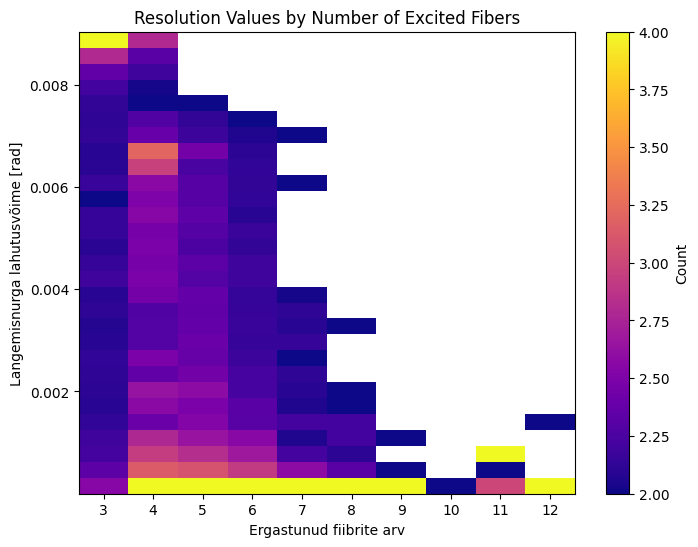

In [13]:
all_data = np.concatenate(y_fibers_val_i)
bins = np.linspace(all_data.min(), all_data.max(), 30)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histograms with heatmap effect
for i, values in enumerate(y_fibers_val_i):
    num_fibers = i + 3  # Calculate the number of fibers
    
    # Create a histogram
    counts, edges = np.histogram(values, bins=bins)
    
    # Create the bar positions
    centers = (edges[:-1] + edges[1:]) / 2
    
    # Plot the histogram bars
    bar_width = (edges[1] - edges[0]) * 0.9
    ax.bar(centers, counts, width=bar_width, color='black', edgecolor='black', alpha=0.5, label=f'{num_fibers} fibers')
    
    # Plot the heatmap
    x = np.full_like(values, num_fibers)
    heatmap = ax.hist2d(x, values, bins=[np.arange(3, len(y_fibers_val_i) + 4) - 0.5, bins], cmap='plasma', cmin=1)

# Customize the plot
ax.set_xlabel('Ergastunud fiibrite arv')
ax.set_ylabel('Langemisnurga lahutusvõime [rad]')
ax.set_xticks(np.arange(3, len(y_fibers_val_i) + 3))
ax.set_xticklabels([f'{i+3}' for i in range(len(y_fibers_val_i))])
# ax.legend()  # Uncomment this if you want to show the legend

plt.colorbar(heatmap[3], ax=ax, label='Count')
plt.title('Resolution Values by Number of Excited Fibers')
plt.show()

In [14]:
import numpy as np
import pylab as pl
import matplotlib.collections as mc

x = x_fibers_val_i
polys = []
values = []
for xs, xe in zip(x[:-1], x[1:]):
    y = np.arange(3,len(x)+3)
    #c = -np.log(xs*y)
    yp = np.c_[y[:-1], y[:-1], y[1:], y[1:]]
    xp = np.repeat([[xs, xe, xe, xs]], len(yp), axis=0)
    points = np.dstack((xp, yp))
    polys.append(points)
    values.append(c[:-1])

polys = np.concatenate(polys, 0)
values = np.concatenate(values, 0)

pc = mc.PolyCollection(polys)
pc.set_array(values)
fig, ax = pl.subplots()
ax.add_collection(pc)
ax.set_yscale("log")
ax.set_xscale("log")
ax.autoscale()    
pl.colorbar(mappable=pc)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 4) + inhomogeneous part.

1478
5548
8064
4606
274
70
14
4
12
6


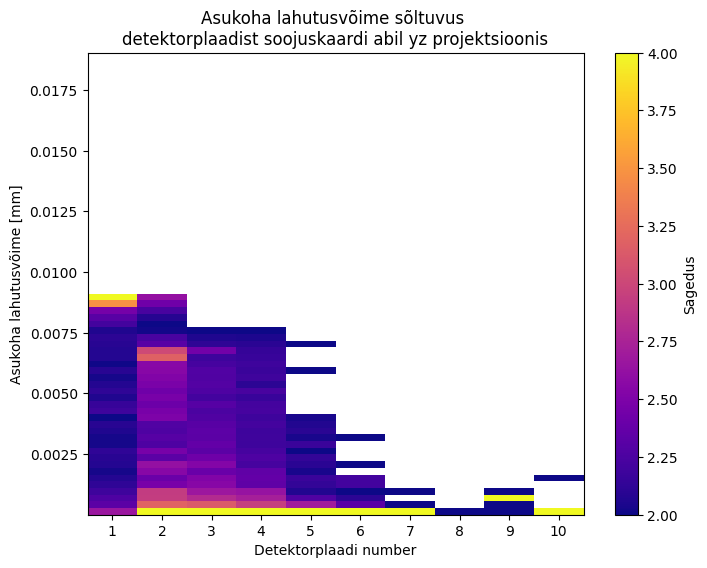

In [27]:
# Determine the bins for the histograms
all_data = np.concatenate(y_fibers_val_i)
bins = np.linspace(all_data.min(), all_data.max()+0.01, 70)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histograms with heatmap effect
for i, values in enumerate(y_fibers_val_i):
    num_fibers = i + 1  # Calculate the number of fibers
    
    # Create a histogram
    counts, edges = np.histogram(values, bins=bins)
    
    # Create the bar positions
    centers = (edges[:-1] + edges[1:]) / 2
    
    # Plot the histogram bars
    bar_width = (edges[1] - edges[0]) * 0
    ax.bar(centers, counts, width=0, color='white', alpha=0.5, label=f'{num_fibers} fibers')
    
    # Plot the heatmap
    x = np.full_like(values, num_fibers)
    heatmap = ax.hist2d(x, values, bins=[np.arange(1, len(y_fibers_val_i) + 2) - 0.5, bins], cmap='plasma', cmin=1)
    print(len(values))

# Customize the plot
ax.set_xlabel('Detektorplaadi number')
ax.set_ylabel('Asukoha lahutusvõime [mm]')
ax.set_xticks(np.arange(1, len(y_fibers_val_i) + 1))
ax.set_xticklabels([f'{i+1}' for i in range(len(y_fibers_val_i))])
#ax.legend()

plt.colorbar(heatmap[3], ax=ax, label='Sagedus')
plt.title("Asukoha lahutusvõime sõltuvus \ndetektorplaadist soojuskaardi abil yz projektsioonis")
plt.show()

In [ ]:
hodo_x_fibers_val=[]
hodo_y_fibers_val=[]
hodo_angle_val_x=[]
angle_val_y=[]
angle_val_3d=[]
vert3_o_2Dx=[]
vert3_o_2Dy=[]
vert_3d=[]
for index, value in event_points_all_df['angle resolution'].items():
    x=value[0]
    y=value[1]
    if not np.isnan(x):
        angle_val_x.append(x)
        x_fibers_val.append(x_fibers[index])
        vert3_o_2Dx.append(abs(event_points_all_df['vert3_o_2Dx'][index]))
    if not np.isnan(y):
        angle_val_y.append(y)
        y_fibers_val.append(y_fibers[index])
        vert3_o_2Dy.append(abs(event_points_all_df['vert3_o_2Dy'][index]))
    if not np.isnan(x) and not np.isnan(y):
        val3d=np.linalg.norm([x,y])
        angle_val_3d.append(val3d)
        vert_3d.append(event_points_all_df['angle'][index])

        

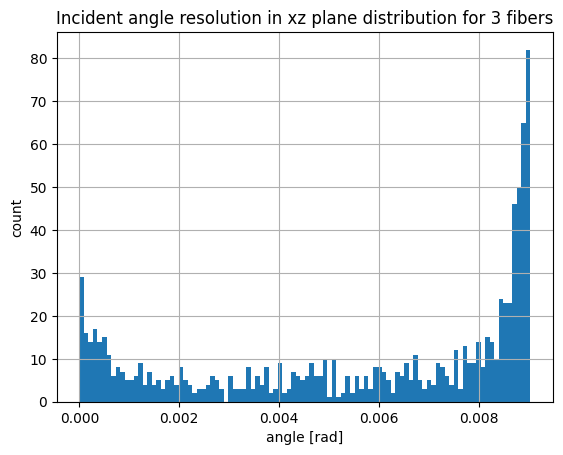

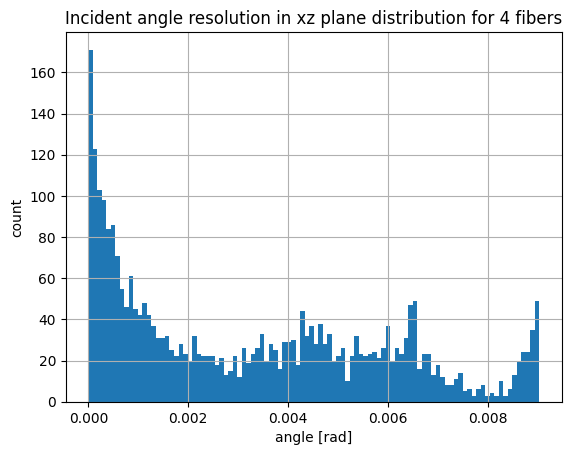

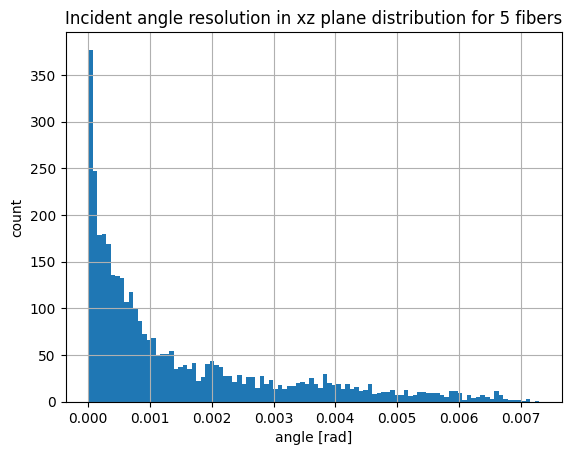

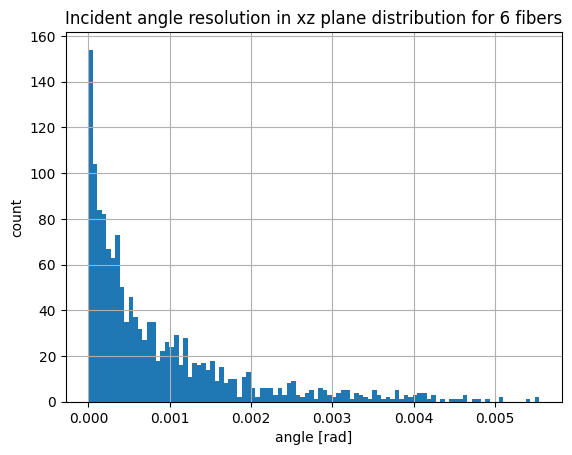

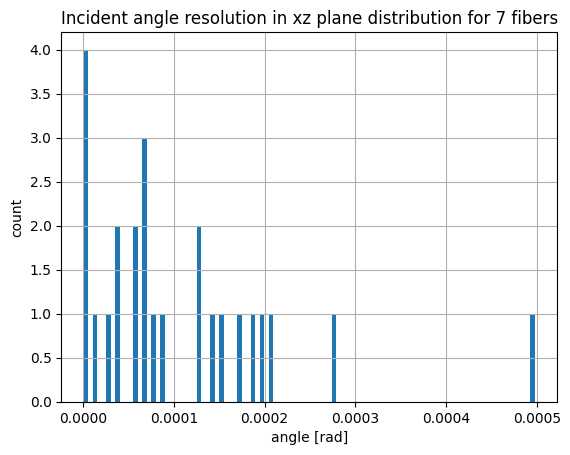

In [42]:
for i in range(5):    
    plt.hist(x_fibers_val_i[i], bins = 100)
    plt.ylabel("count")
    plt.xlabel("angle [rad]")
    plt.title("Incident angle resolution in xz plane distribution for "+ str(i+3)+ " fibers")
    plt.grid()
    plt.show()

3632


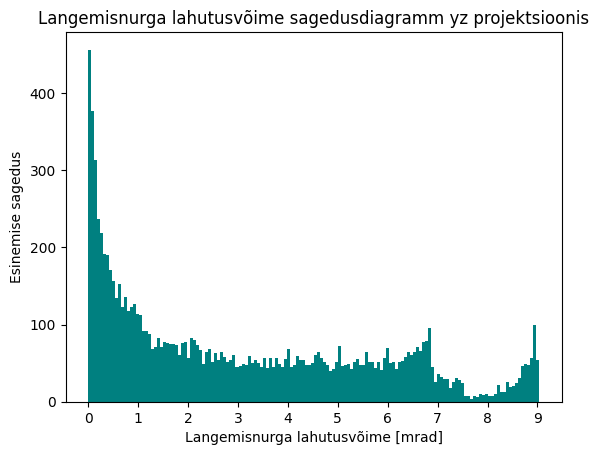

In [12]:
plt.clf()

cols = ['angle resolution']
angle_val_x_1000=np.array(angle_val_x)*1000
angle_val_y_1000=np.array(angle_val_y)*1000
plt.hist(angle_val_y_1000, bins = 150, color='teal')
plt.xticks(range(0, 10, 1))  # Vahemik 0 kuni 10, sammuga 1

plt.ylabel("Esinemise sagedus")
plt.xlabel("Langemisnurga lahutusvõime [mrad]")
plt.title("Langemisnurga lahutusvõime sagedusdiagramm yz projektsioonis")
plt.grid(False)
print(len(angle_val_3d))

In [ ]:
def angle_points(x):
    
#    anl = 180.
#    ver1 = 180.
#    ver2 = 180.
#    ver3 = 180.
#    for p1 in x[0]:
#        for p2 in x[1]:
#            for p3 in x[2]:
#                for p4 in x[3]:
#                    for p5 in x[4]:
#                        for p6 in x[5]:
#                            new_ps = [new_points([p1,p2]),new_points([p3,p4]),new_points([p5,p6])]
#                            
#                            vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
#                            
#                            angl = angle(vects[0], vects[1])/np.pi*180
#                            
#                            if angl < anl:
#                                anl = angl
#                                ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
#                                ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
#                                ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    anl = 180.
    pc1 = x[0][0]
    pc3 = x[2][0]
    pc5 = x[4][0]
    for p1 in x[0]:
        for p3 in x[2]:
            for p5 in x[4]:
                vects = [p3 - p1, p5 - p3]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc1 = p1
                    pc3 = p3
                    pc5 = p5
    anl = 180.
    pc2 = x[1][0]
    pc4 = x[3][0]
    pc6 = x[5][0]
    for p2 in x[1]:
        for p4 in x[3]:
            for p6 in x[5]:
                vects = [p4 - p2, p6 - p4]
                
                angl = angle(vects[0], vects[1])/np.pi*180
                
                if angl < anl:
                    anl = angl
                    pc2 = p2
                    pc4 = p4
                    pc6 = p6

    new_ps = [new_points([pc1,pc2]),new_points([pc3,pc4]),new_points([pc5,pc6])]
    
    vects = [new_ps[1] - new_ps[0], new_ps[2] - new_ps[1], new_ps[2] - new_ps[0]]
    
    angul = angle(vects[0], vects[1])/np.pi*180

    ver1 = angle(np.array([-1.,0.,0.]), vects[0])/np.pi*180
    ver2 = angle(np.array([-1.,0.,0.]), vects[1])/np.pi*180
    ver3 = angle(np.array([-1.,0.,0.]), vects[2])/np.pi*180
    
    return angul, ver1, ver2, ver3

Angle calculations

In [ ]:
colis = [i for i in range(0,6)]

event_points_df = pd.DataFrame(event_points, columns = ['event'] + colis) 
#event_points_5_df = pd.DataFrame(event_points_5, columns = colis)
event_points_df['angle'] = event_points_df[colis].apply(lambda x: angle_points(x)[0], axis = 1)


event_points_df['vert1'] = event_points_df[colis].apply(lambda x: angle_points(x)[1], axis = 1)

event_points_df['vert2'] = event_points_df[colis].apply(lambda x: angle_points(x)[2], axis = 1)

event_points_df['vert3'] = event_points_df[colis].apply(lambda x: angle_points(x)[3], axis = 1)

####################################
event_points_df['angle_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[0], axis = 1)

event_points_df['vert1_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[1], axis = 1)

event_points_df['vert2_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[2], axis = 1)

event_points_df['vert3_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[3], axis = 1)

###################################
event_points_df['angle_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[0], axis = 1)

event_points_df['vert1_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[1], axis = 1)

event_points_df['vert2_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[2], axis = 1)

event_points_df['vert3_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[3], axis = 1)

###################################
event_points_df['angle_o_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[4], axis = 1)

event_points_df['vert1_o_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[5], axis = 1)

event_points_df['vert2_o_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[6], axis = 1)

event_points_df['vert3_o_2Dx'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 0)[7], axis = 1)

###################################
event_points_df['angle_o_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[4], axis = 1)

event_points_df['vert1_o_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[5], axis = 1)

event_points_df['vert2_o_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[6], axis = 1)

event_points_df['vert3_o_2Dy'] = event_points_df[colis].apply(lambda x: angle_points_2D(x, 1)[7], axis = 1)
#print(event_points_df.loc[0])
###################################
#event_points_5_df['angle'] = event_points_5_df[colis].apply(lambda x: angle_points_5(x)[0], axis = 1)

#event_points_5_df['vert1'] = event_points_5_df[colis].apply(lambda x: angle_points_5(x)[1], axis = 1)

#event_points_5_df['vert2'] = event_points_5_df[colis].apply(lambda x: angle_points_5(x)[2], axis = 1)

#event_points_5_df['vert3'] = event_points_5_df[colis].apply(lambda x: angle_points_5(x)[3], axis = 1)



KeyboardInterrupt: 

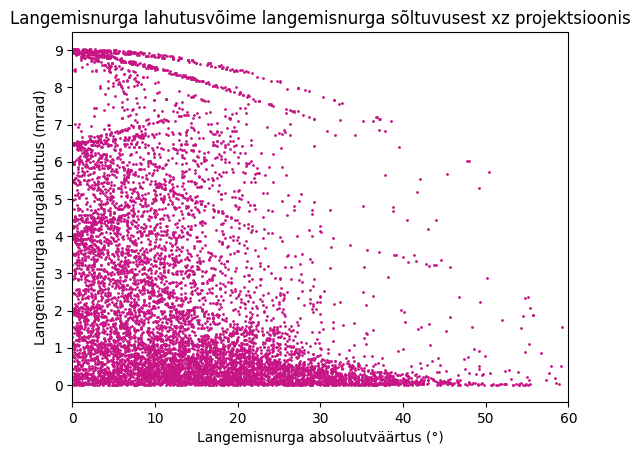

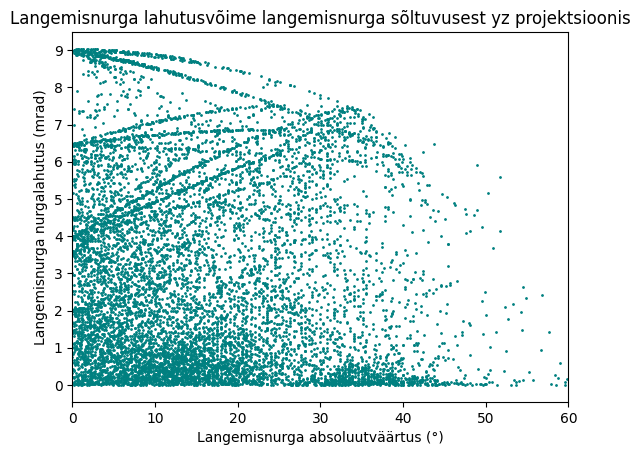

In [ ]:
plt.plot(vert3_o_2Dx,angle_val_x_1000, 'mediumvioletred',marker='.',linestyle='', markersize=2)
plt.xlim(0,60)
plt.yticks(range(0, 10, 1))  # Vahemik 0 kuni 10, sammuga 1
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.ylabel('Langemisnurga nurgalahutus (mrad)')
plt.title('Langemisnurga lahutusvõime langemisnurga sõltuvusest xz projektsioonis')
plt.grid(False)
plt.show()


plt.plot(vert3_o_2Dy,angle_val_y_1000, 'teal',marker='.',linestyle='', markersize=2)
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.xlim(0,60)
plt.yticks(range(0, 10, 1))  # Vahemik 0 kuni 10, sammuga 1
plt.ylabel('Langemisnurga nurgalahutus (mrad)')
plt.title('Langemisnurga lahutusvõime langemisnurga sõltuvusest yz projektsioonis')
plt.grid(False)
plt.show()

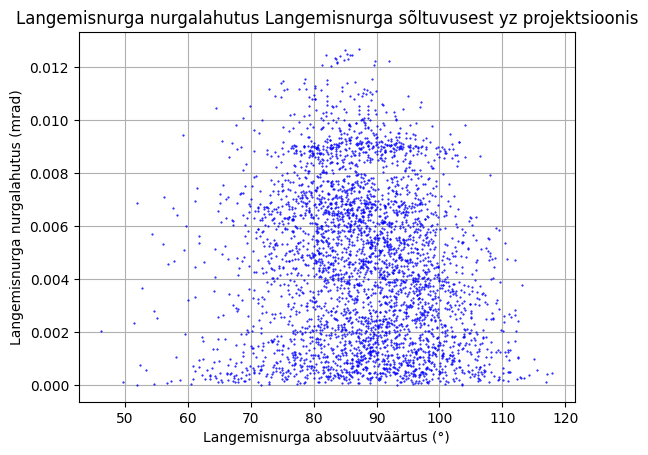

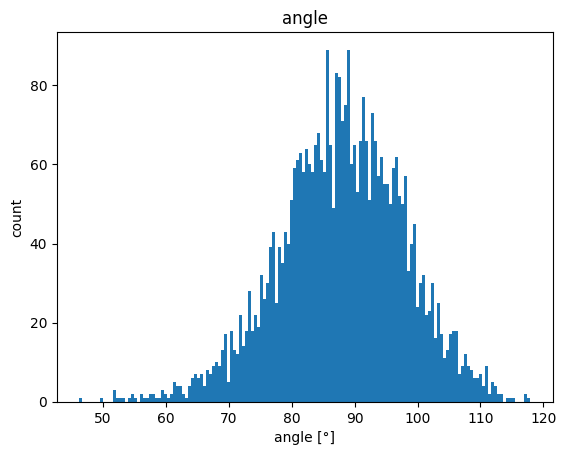

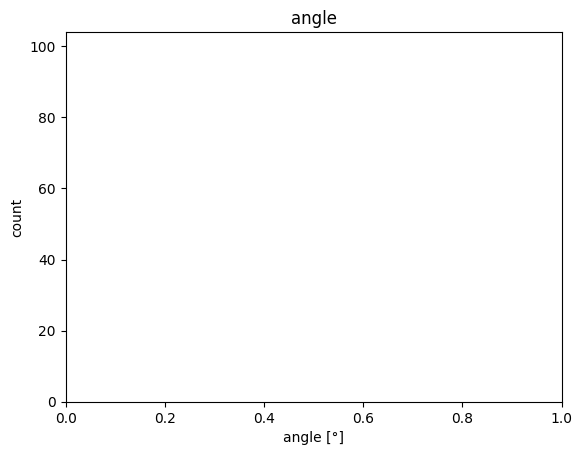

In [ ]:
plt.plot(vert_3d,angle_val_3d, 'b.', markersize=1)
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.ylabel('Langemisnurga nurgalahutus (mrad)')
plt.title('Langemisnurga nurgalahutus Langemisnurga sõltuvusest yz projektsioonis')
plt.grid(True)
plt.show()

plt.clf()

value = 'angle'

plt.hist(vert_3d, bins = 150)
plt.ylabel("count")
plt.xlabel("angle [°]")
plt.title(value)
plt.show()


plt.hist(event_points_all_df['angle'], bins = 10000)
plt.ylabel("count")
plt.xlabel("angle [°]")
plt.xlim(0,1)
plt.title(value)
plt.show()

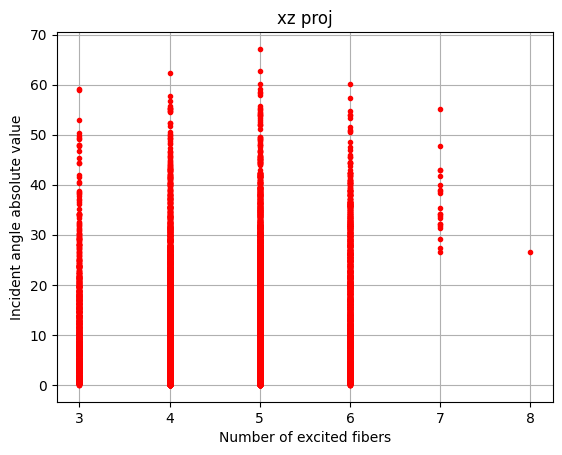

In [ ]:
# plt.plot(x_fibers_val,vert3_o_2Dx, 'r.')
# plt.ylabel('Incident angle absolute value')
# plt.xlabel('Number of excited fibers')
# plt.title('xz proj')
# plt.grid(True)
# plt.show()

In [ ]:
x_fibers_val_i=[[],[],[],[],[],[]]
for i in range(len(x_fibers_val)):
    ind=x_fibers_val[i]
    x_fibers_val_i[ind-3].append(angle_val_x[i])

y_fibers_val_i=[[],[],[],[],[],[],[],[],[],[]]
for i in range(len(y_fibers_val)):
    ind=y_fibers_val[i]
    y_fibers_val_i[ind-3].append(angle_val_y[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


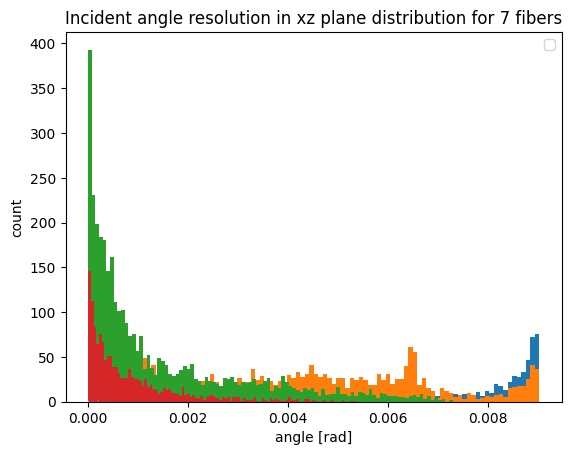

In [ ]:
print(len(x_fibers_val_i))
for i in range(5):    
    plt.hist(x_fibers_val_i[i], bins = 100)
    plt.ylabel("count")
    plt.xlabel("angle [rad]")
    plt.title("Incident angle resolution in xz plane distribution for "+ str(i+3)+ " fibers")
    plt.legend()
    plt.grid(False)
    #plt.show()
    tuhh=np.asarray(x_fibers_val_i[i])*1000
    #print(np.median(tuhh))
    # s cf print(round(np.mean(tuhh),3))


In [ ]:

# vert3_o_2Dx_i=[[],[],[],[],[],[],[],[],[],[]]
# angle_val_x_i=[[],[],[],[],[],[],[],[],[],[]]
# for i in range(len(x_fibers_val)):
#     ind=y_fibers_val[i]
#     vert3_o_2Dx_i[ind-3].append(vert3_o_2Dx[i])
#     angle_val_x_i[ind-3].append(angle_val_x[i])

# for i in range(7):    
#     plt.plot(vert3_o_2Dx_i[i],angle_val_x_i[i],'b.')
#     plt.ylabel("Incident angle angular resolution")
#     plt.xlabel("Incident angle")
#     plt.title("Incident angle resolution dependance on incident angle in xz plane distribution for "+ str(i+3)+ " fibers")
#     plt.grid()
#     plt.show()

In [5]:
def by_mat_nr(p0,p1,p2,angle_res,vertical,n):
    two_system_angles = [np.array([]) for _ in range(235)]
    vert= [np.array([]) for _ in range(235)]
    #xz jaoks koordinaadid
    pc1 = p0
    pc3 = p1
    pc5 = p2
    pc1_num = np.array([len(row) for row in pc1])
    pc3_num = np.array([len(row) for row in pc3])
    pc5_num = np.array([len(row) for row in pc5])
    #p135=np.concatenate((pc1,pc3,pc5), axis=0)
    #angle_res = np.array(angle_res, dtype=np.float64)
    #arr_without_nan = angle_res[~np.isnan(angle_res)]
    #rows_with_nan = np.any(np.isnan(angle_res), axis=1)

    # Filter out rows with NaN
    #angle_res_without_nan = angle_res[~rows_with_nan]
    variations = np.array([[i, j, k] for i in range(1,  6) for j in range(1, 6) for k in range(1, 6)])
    for i, (pc1_row, pc3_row, pc5_row) in enumerate(zip(pc1_num, pc3_num, pc5_num)):
        # Compare the current row with each variation
        for index, variation in enumerate(variations):
            if np.array_equal([pc1_row, pc3_row, pc5_row], variation) and not np.isnan(angle_res[i][0]):
                # If the current row matches a variation, add its index to two_system_angles_x
                two_system_angles[index] = np.append(two_system_angles[index], angle_res[i][n]*1000)
                vert[index]=np.append(vert[index],vertical[i])
                break
    return two_system_angles,vert



In [6]:
def pieces(event_points_res_df):
    p0= event_points_res_df[0].values
    p1= event_points_res_df[1].values
    p2= event_points_res_df[2].values
    p3= event_points_res_df[3].values
    p4= event_points_res_df[4].values
    p5= event_points_res_df[5].values
    angle_res=event_points_res_df['angle resolution'].values
    return p0,p1,p2,p3,p4,p5,angle_res

In [7]:
event_points_all_df=event_points_all_df0
p0,p1,p2,p3,p4,p5,angle_res=pieces(event_points_all_df)
two_system_angles_x,vert_x=by_mat_nr(p0,p2,p4,angle_res,event_points_all_df['vert3_o_2Dx'].values,0)
two_system_angles_y,vert_y=by_mat_nr(p1,p3,p5,angle_res,event_points_all_df['vert3_o_2Dy'].values,1)

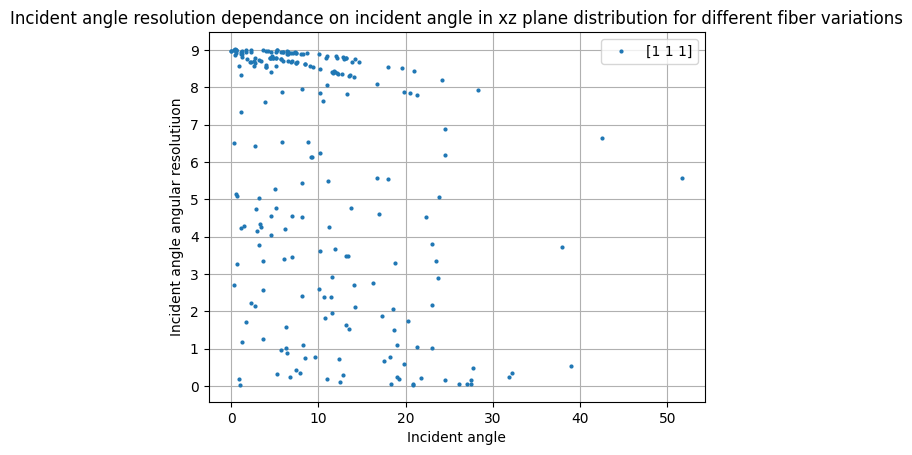

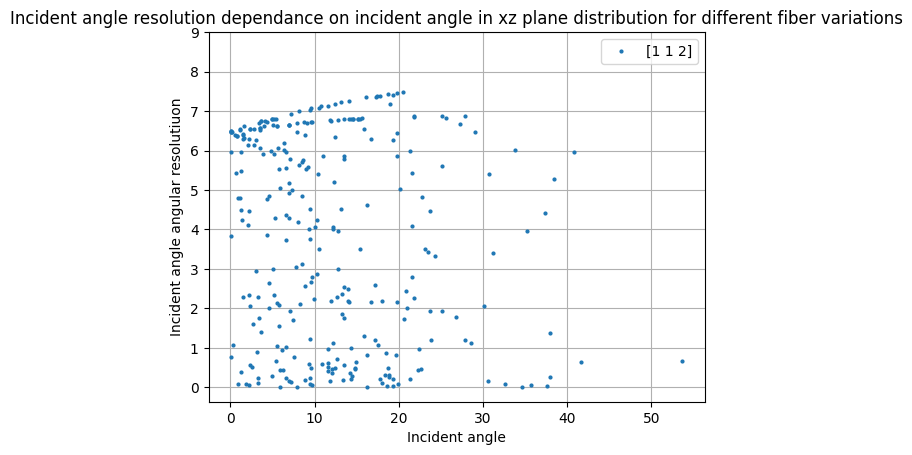

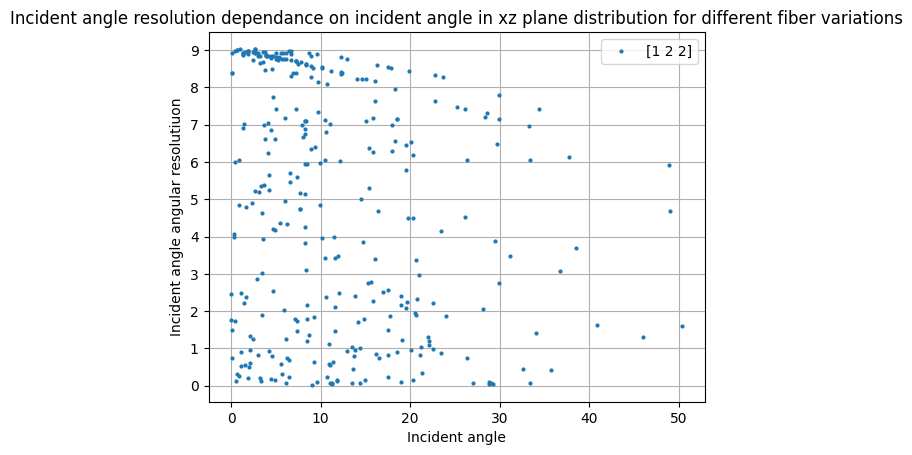

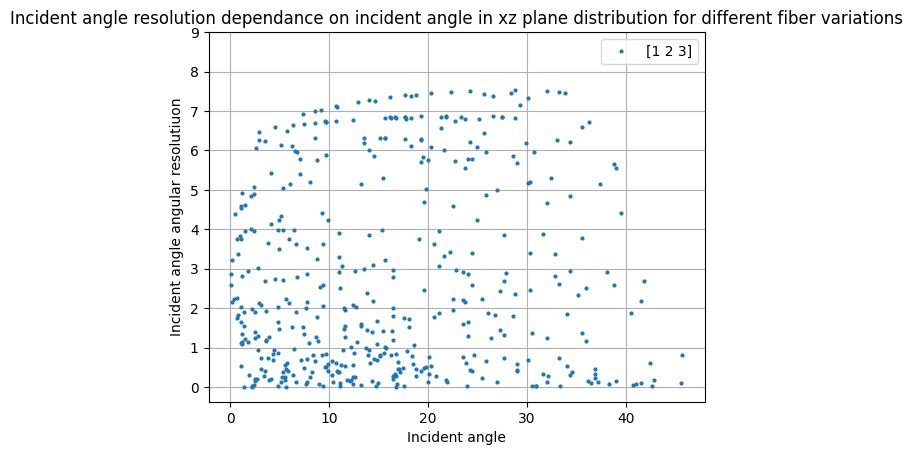

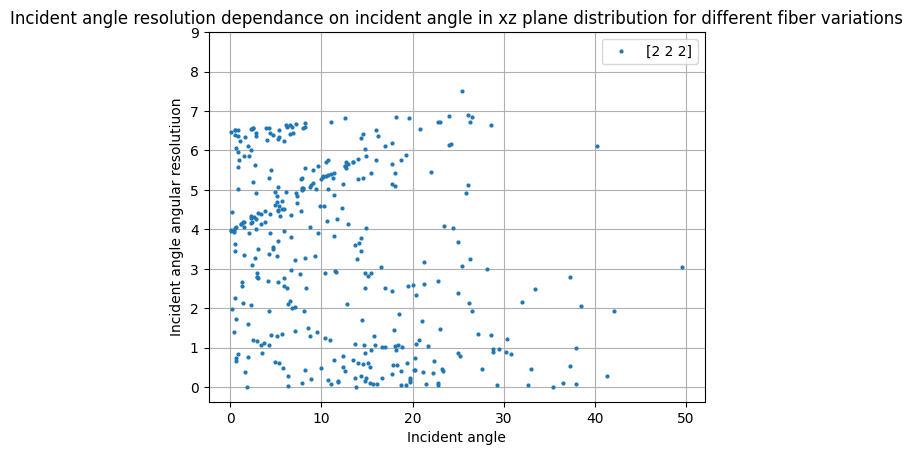

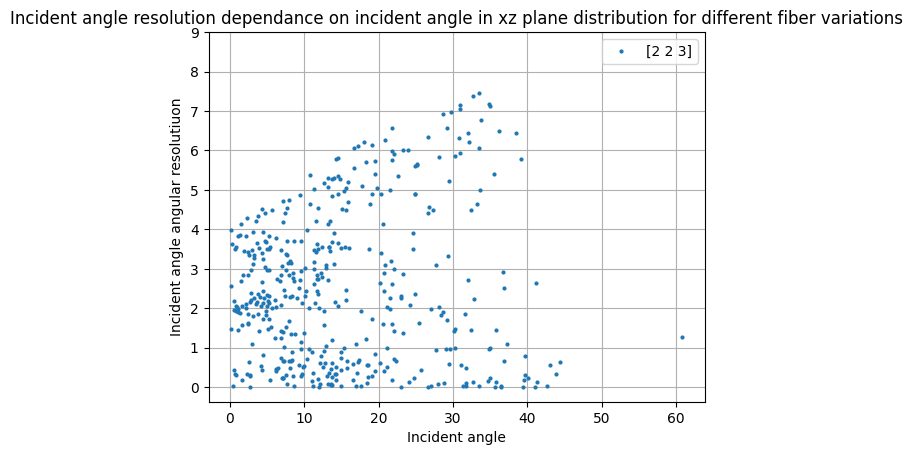

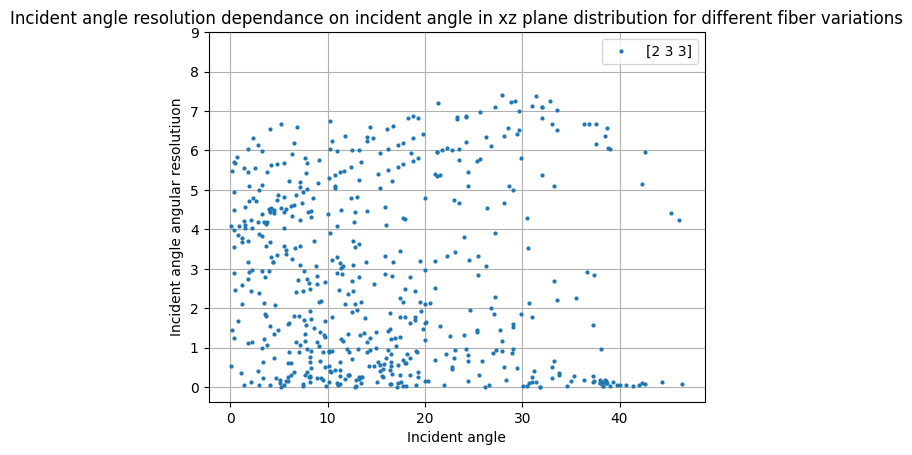

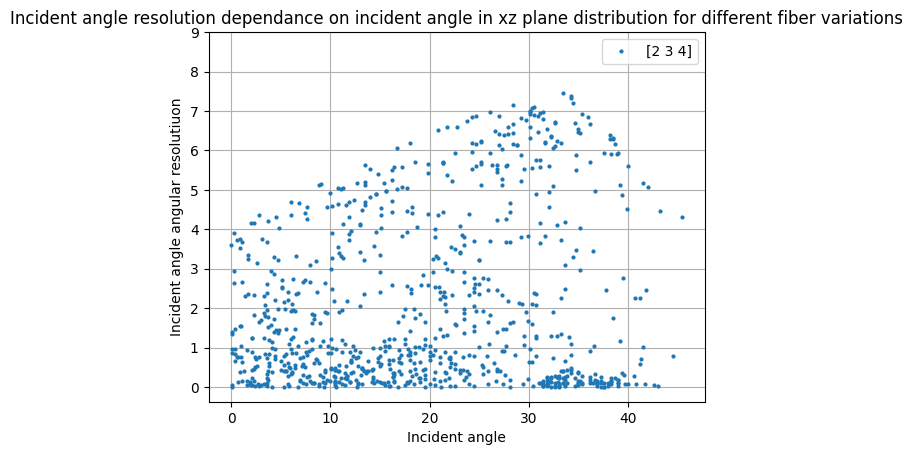

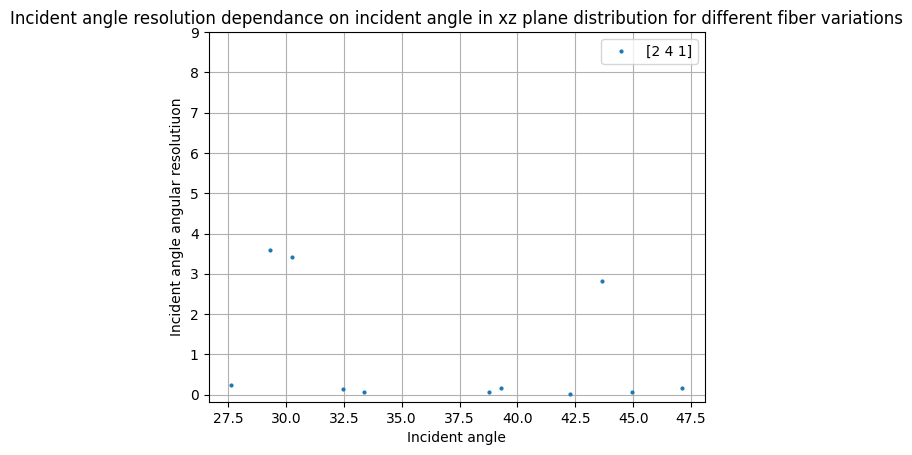

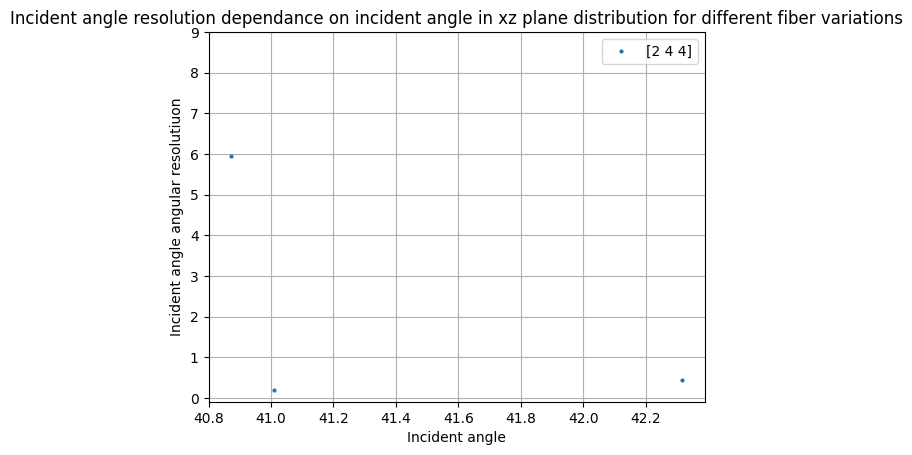

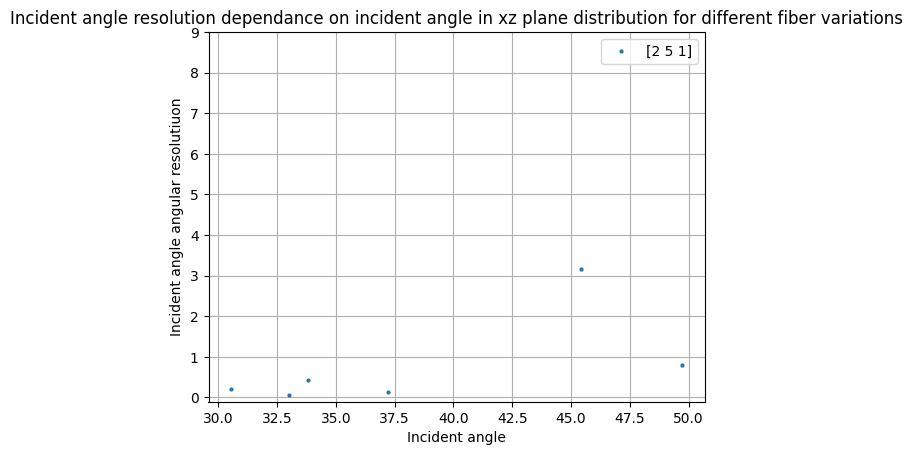

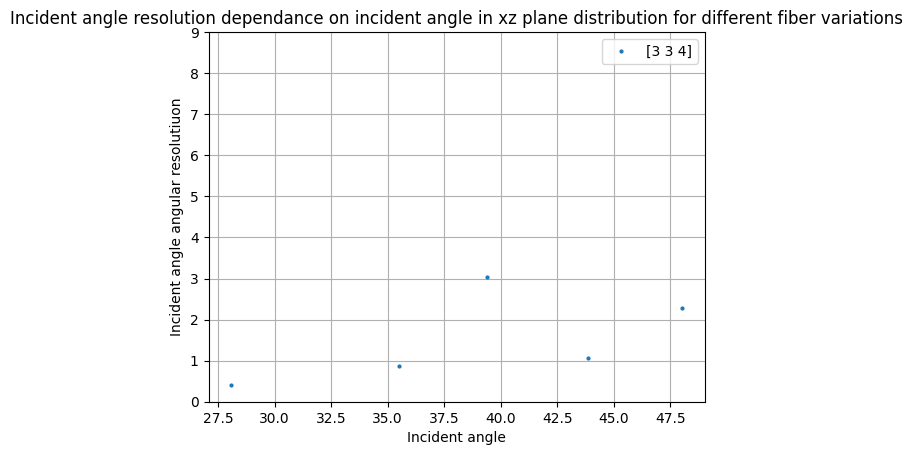

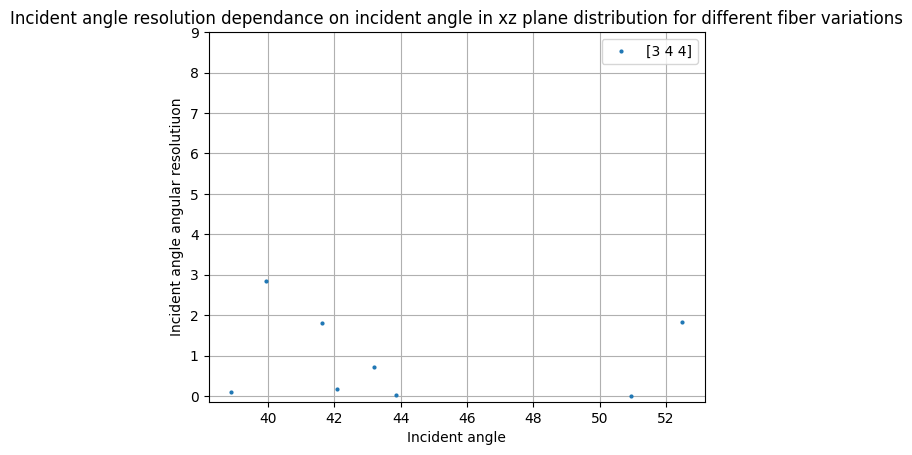

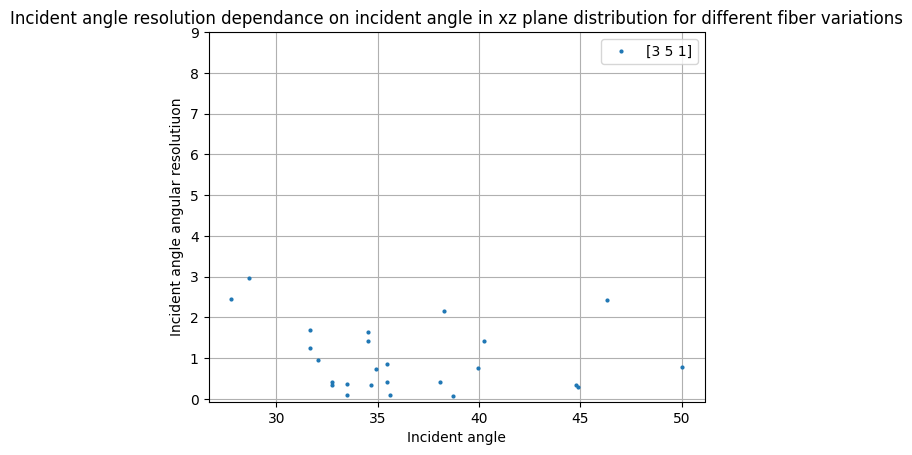

In [22]:
variations = np.array([[i, j, k] for i in range(1,  6) for j in range(1, 6) for k in range(1, 5)])
colors = ['black', 'red', 'magenta', 'red','lime', 'orange', 'blue', 'green','pink','cyan']
p=0
for i in range(len(two_system_angles_y)):
    if two_system_angles_y[i].size<50:
        continue
    #if np.array_equal(variations[i],[1,1,1]) or np.array_equal(variations[i],[1,2,2]):
    plt.plot(abs(vert_y[i]),two_system_angles_y[i],label=variations[i],marker='.',linestyle='',markersize=4)
    #p+=1
    plt.ylabel("Incident angle angular resolutiuon")
    plt.xlabel("Incident angle")
    plt.title("Incident angle resolution dependance on incident angle in xz plane distribution for different fiber variations")
    plt.grid()
    plt.legend()
    
    plt.yticks(np.arange(0, 10, 1))
    #plt.savefig("fiber_variation_all_x.jpg", dpi=150, format = 'jpg')
    plt.show()


In [39]:
def hodoscope_res(x,angle_res):
    radius=0.45
    #x koord jaoks:
    pc1 = x[0]
    pc3 = x[2]
    pc5 = x[4]
    pc2 = x[1]
    pc4 = x[3]
    pc6 = x[5]
    hodo_angle_res=[]
    for i in range(len(angle_res)):
        if i==0:
            points12= np.concatenate((pc1,pc3),axis=0)
            points23=np.concatenate((pc3,pc5),axis=0)
        elif i==1:
            points12= np.concatenate((pc2,pc4),axis=0)
            points23=np.concatenate((pc4,pc6),axis=0)
        if np.isnan(angle_res[i]):    
            line_l12, line_r12 = nurk.find_line_through_points(points12,radius)
            new_line12 = nurk.move_line_to_distance(points12, line_l12, radius=0.45)
            new_line212 = nurk.move_line_to_distance(points12, line_r12, radius)
            
            line_l23, line_r23 = nurk.find_line_through_points(points23,radius)
            new_line23 = nurk.move_line_to_distance(points23, line_l23, radius=0.45)
            new_line232 = nurk.move_line_to_distance(points23, line_r23, radius)


            hodo_angle1=nurk.find_angle_between_lines(new_line12, new_line212)
            hodo_angle2=nurk.find_angle_between_lines(new_line23, new_line232)
            if np.isnan(hodo_angle1)==False and np.isnan(hodo_angle2)==False: 
                hodo_angle_res1=np.linalg.norm([hodo_angle1, hodo_angle2])
                hodo_angle_res.append(hodo_angle_res1)
            else:
                hodo_angle_res.append(np.nan)
        else:
            hodo_angle_res.append(np.nan)
    
    return hodo_angle_res


In [47]:
def hodoscope_res_all(x,angle_res):
    radius=0.45
    #x koord jaoks:
    pc1 = x[0]
    pc3 = x[2]
    pc5 = x[4]
    pc2 = x[1]
    pc4 = x[3]
    pc6 = x[5]
    hodo_angle_res=[]
    for i in range(len(angle_res)):
        if i==0:
            points12= np.concatenate((pc1,pc3),axis=0)
            points23=np.concatenate((pc3,pc5),axis=0)
        elif i==1:
            points12= np.concatenate((pc2,pc4),axis=0)
            points23=np.concatenate((pc4,pc6),axis=0)
        if np.isnan(angle_res[i]):    
            line_l12, line_r12 = nurk.find_line_through_points(points12,radius)
            new_line12 = nurk.move_line_to_distance(points12, line_l12, radius=0.45)
            new_line212 = nurk.move_line_to_distance(points12, line_r12, radius)
            
            line_l23, line_r23 = nurk.find_line_through_points(points23,radius)
            new_line23 = nurk.move_line_to_distance(points23, line_l23, radius=0.45)
            new_line232 = nurk.move_line_to_distance(points23, line_r23, radius)

            hodo_angle1=nurk.find_angle_between_lines(new_line12, new_line212)
            hodo_angle2=nurk.find_angle_between_lines(new_line23, new_line232)
                #hodo_angle_res1=np.linalg.norm([hodo_angle1, hodo_angle2])
            hodo_angle_res.append([hodo_angle1, hodo_angle2])
        else:
            hodo_angle_res.append(np.nan)
    
    return hodo_angle_res

In [ ]:
event_points_all_df['hodoscope angle resolution'] = event_points_all_df.apply(lambda row: hodoscope_res(row[colis], row['angle resolution']), axis=1)

In [49]:
colis = [i for i in range(0,6)]

event_points_all_df['hodoscope all angle resolution'] = event_points_all_df.apply(lambda row: hodoscope_res_all(row[colis], row['angle resolution']), axis=1)


In [16]:
event_points_all_df.head()

,event,0,1,2,3,4,5,6,7,8,...,10,11,angle resolution,vert3_o_2Dx,vert3_o_2Dy,resolution lines,position resolution,fibers sum,hodoscope angle resolution,hodoscope all angle resolution
0,705304748092516,"[[409.5, 200.0], [409.0, 199.25167]]","[[766.5, 198.0], [646.0, 197.25167]]","[[446.5, 100.0], [446.0, 99.25167]]","[[706.5, 98.0], [707.0, 97.25167]]","[[496.5, 0.0]]","[[769.5, -2.0]]","[[199.625835, 409.25]]","[[198.0, 766.5], [197.625835, 645.75]]","[[99.625835, 446.25]]",...,"[[0.0, 496.5], [-0.74833, 482.0]]","[[-2.0, 769.5], [-2.74833, 768.0]]","[nan, nan]",19.954479,31.387725,"([[nan, nan], [nan, nan]], [[nan, nan], [nan, ...","(nan, nan, nan, nan, nan, nan)","(5, 5)","[0.004556997746996451, nan]","[[0.0017914625112139364, 0.003050772840535934]..."
1,705320962975626,"[[225.5, 200.0]]","[[1251.5, 198.0], [1250.5, 198.0]]","[[260.5, 100.0], [251.0, 99.25167]]","[[1181.5, 98.0]]","[[315.5, 0.0], [315.0, -0.74833]]","[[1163.5, -2.0], [1164.0, -2.74833]]","[[200.0, 225.5], [200.0, 186.5], [199.25167, 2...","[[198.0, 1251.0], [198.0, 1133.5], [198.0, 102...","[[100.0, 260.5], [99.625835, 251.25]]",...,"[[-0.374165, 315.25]]","[[-2.374165, 1163.75]]","[nan, nan]",32.722688,8.584975,"([[nan, nan], [nan, nan]], [[nan, nan], [nan, ...","(nan, nan, nan, nan, nan, nan)","(5, 5)","[nan, 0.010436006998908919]","[[nan, nan], [0.0001805133865413728, 0.0111457..."
2,705326433858015,"[[671.5, 200.0], [671.0, 199.25167]]","[[468.5, 198.0]]","[[652.5, 100.0]]","[[453.5, 98.0]]","[[637.5, 0.0], [638.0, -0.74833]]","[[431.5, -2.0], [431.0, -2.74833]]","[[199.625835, 671.25]]","[[198.0, 468.5]]","[[100.0, 652.5], [99.25167, 717.0]]",...,"[[-0.374165, 637.75]]","[[-2.374165, 431.25]]","[nan, nan]",-9.508772,-10.531192,"([[nan, nan], [nan, nan]], [[nan, nan], [nan, ...","(nan, nan, nan, nan, nan, nan)","(5, 4)","[0.016196984886135028, 0.02233629648951783]","[[0.010737844197567459, 0.011627931613112204],..."
3,705326656715170,"[[178.5, 200.0]]","[[667.0, 197.25167]]","[[186.5, 100.0]]","[[675.5, 98.0], [676.0, 97.25167]]","[[99.0, -0.74833]]","[[685.5, -2.0], [685.0, -2.74833]]","[[200.0, 178.5], [199.25167, 177.0]]","[[197.25167, 667.0]]","[[100.0, 186.5], [99.25167, 155.0]]",...,"[[-0.74833, 99.0]]","[[-2.374165, 685.25]]","[nan, 0.0012101372884851152]",-21.604469,5.223519,"([[nan, nan], [nan, nan]], [[nan, nan], [nan, ...","(nan, 0.02230743557004189, nan, 0.046743798704...","(3, 5)","[0.020911712577316794, nan]","[[0.013633999382472289, 0.012082596059406201],..."
4,705340077061921,"[[501.5, 200.0], [502.0, 199.25167]]","[[615.5, 198.0]]","[[377.5, 100.0]]","[[695.5, 98.0], [696.0, 97.25167]]","[[256.5, 0.0]]","[[777.5, -2.0], [778.0, -2.74833]]","[[199.625835, 501.75]]","[[198.0, 615.5], [198.0, 512.5], [197.25167, 6...","[[100.0, 377.5], [99.25167, 379.0]]",...,"[[0.0, 256.5], [-0.74833, 289.0]]","[[-2.374165, 777.75]]","[nan, nan]",-50.855488,39.016669,"([[nan, nan], [nan, nan]], [[nan, nan], [nan, ...","(nan, 0.02139314553028271, nan, 0.026062892103...","(4, 5)","[0.010559032497013496, 0.0049961804195282735]","[[0.002402008806234748, 0.00911843415453446], ..."


In [33]:
vert3_o_2Dx=[]
vert3_o_2Dy=[]
#fib=np.array(event_points_all_df['fibers sum'])
#x_fibers = [pair[0] for pair in fib]
#y_fibers=[pair[1] for pair in fib]
#x_fibers_val=[]
#y_fibers_val=[]
hodo_angle_val_x=[]
hodo_angle_val_y=[]
hodo_angle_val_3d=[]
hodo_vert3d=[]
for index, value in event_points_all_df['hodoscope angle resolution'].items():
    x=value[0]
    y=value[1]
    if not np.isnan(x):
        hodo_angle_val_x.append(x*1000)
        vert3_o_2Dx.append(abs(event_points_all_df['vert3_o_2Dx'][index]))
        #x_fibers_val.append(x_fibers[index])
    if not np.isnan(y):
        hodo_angle_val_y.append(y*1000)
        vert3_o_2Dy.append(abs(event_points_all_df['vert3_o_2Dy'][index]))
        #y_fibers_val.append(y_fibers[index])
    if not np.isnan(x) and not np.isnan(y):
        hodo3d_i=np.linalg.norm([x,y])*1000
        hodo_angle_val_3d.append(hodo3d_i)
        #hodo_vert3d.append(event_points_all_df['angle'][index])

In [15]:
hodo_all_x_1=[]
hodo_all_x_2=[]
hodo_all_y_1=[]
hodo_all_y_2=[]
hodo_all_verx1=[]
hodo_all_verx2=[]
hodo_all_very1=[]
hodo_all_very2=[]
for index, value in event_points_all_df['hodoscope all angle resolution'].items():
    if isinstance(value[0], list):
        x1=value[0][0]
        x2=value[0][1]
    if not np.isnan(x1):
        hodo_all_x_1.append(x1*1000)
        hodo_all_verx1.append(abs(event_points_all_df['vert3_o_2Dx'][index]))
    if not np.isnan(x2):
        hodo_all_x_2.append(x2*1000)
        hodo_all_verx2.append(abs(event_points_all_df['vert3_o_2Dx'][index]))
    if isinstance(value[1], list):
        y1=value[1][0]
        y2=value[1][1]
    if not np.isnan(y1):
        hodo_all_y_1.append(y1*1000)
        hodo_all_very1.append(abs(event_points_all_df['vert3_o_2Dy'][index]))
    if not np.isnan(y2):
        hodo_all_y_2.append(y2*1000)
        hodo_all_very2.append(abs(event_points_all_df['vert3_o_2Dy'][index]))

48747 43884


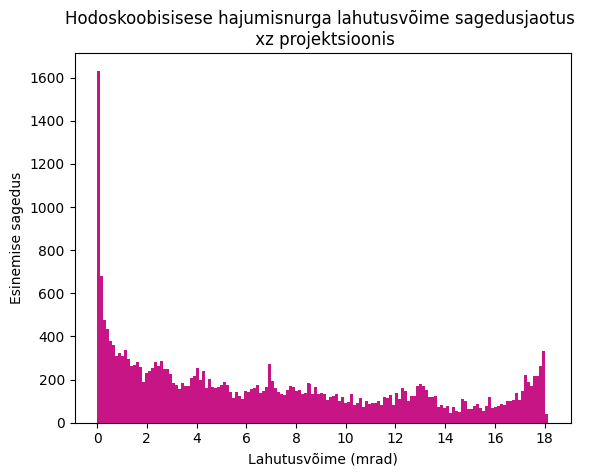

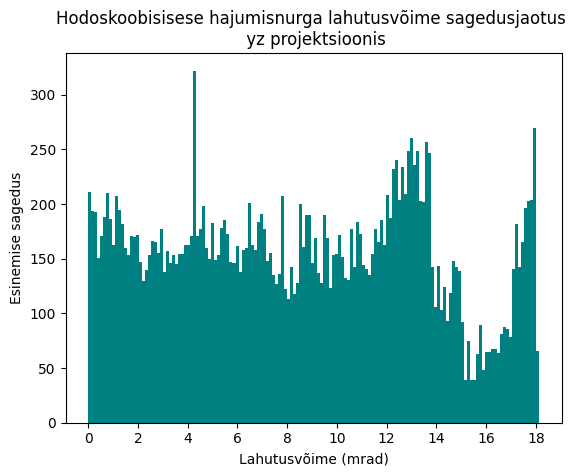

In [19]:
plt.hist(hodo_all_x_1, bins = 150,color='mediumvioletred')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n xz projektsioonis")

#plt.ylim(0,400)
hodo_all_x=len(hodo_all_x_1)+len(hodo_all_x_2)
hodo_all_y=len(hodo_all_y_1)+len(hodo_all_y_2)
print(hodo_all_x,hodo_all_y)
plt.hist(hodo_all_x_2, bins = 150,color='mediumvioletred')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n xz projektsioonis")

plt.xticks(range(0, 19, 2))
plt.show()

plt.hist(hodo_all_y_1, bins = 150,color='teal')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n xz projektsioonis")

plt.xticks(range(0, 19, 2))


plt.hist(hodo_all_y_2, bins = 150,color='teal')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n yz projektsioonis")

#plt.xticks(range(0, 19, 2))
plt.show()

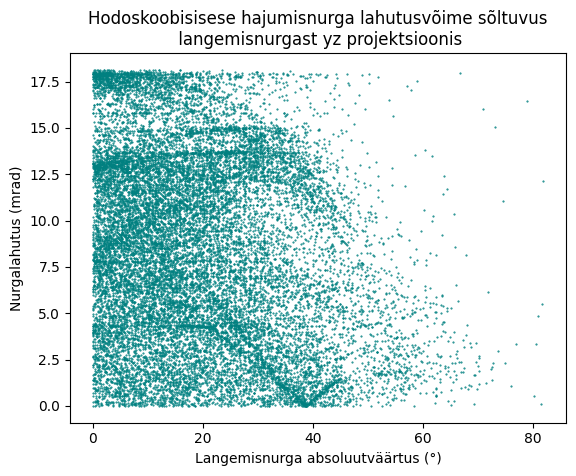

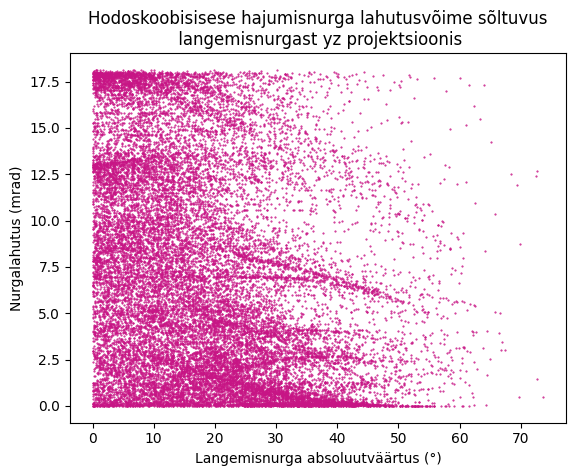

In [35]:
plt.plot(hodo_all_very1,hodo_all_y_1,'teal',marker='.',linestyle='', markersize=1)
#plt.plot(hodo_all_very2,hodo_all_y_2,'teal',marker='.',linestyle='', markersize=1)
#plt.yticks(range(0, 26, 5))  # Vahemik 0 kuni 10, sammuga 1
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.ylabel('Nurgalahutus (mrad)')
plt.title('Hodoskoobisisese hajumisnurga lahutusvõime sõltuvus\n langemisnurgast yz projektsioonis')
plt.grid(False)
plt.show()

plt.plot(hodo_all_verx1,hodo_all_x_1,'mediumvioletred',marker='.',linestyle='', markersize=1)
#plt.plot(hodo_all_very2,hodo_all_y_2,'teal',marker='.',linestyle='', markersize=1)
#plt.yticks(range(0, 26, 5))  # Vahemik 0 kuni 10, sammuga 1
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.ylabel('Nurgalahutus (mrad)')
plt.title('Hodoskoobisisese hajumisnurga lahutusvõime sõltuvus\n langemisnurgast yz projektsioonis')
plt.grid(False)
plt.show()

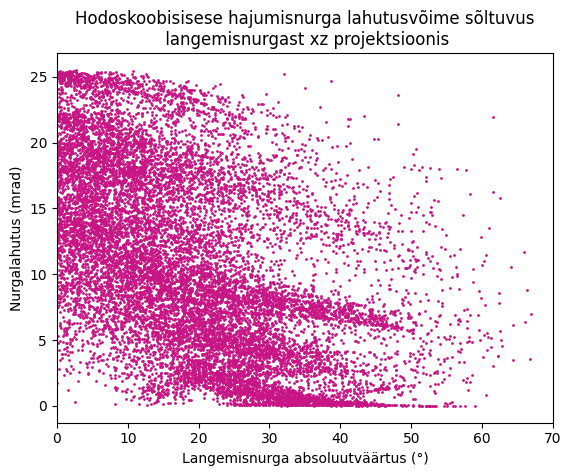

15129


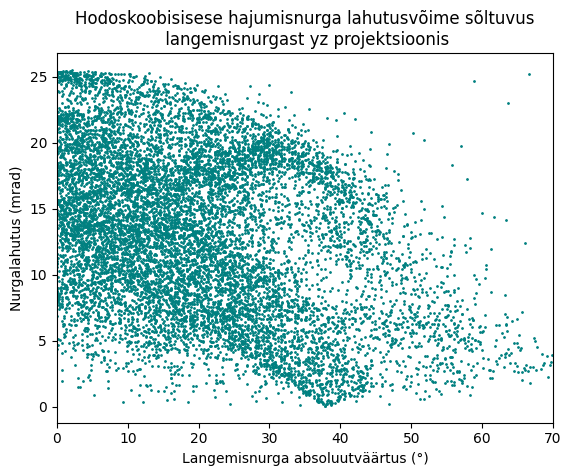

11745


In [36]:
plt.plot(vert3_o_2Dx,hodo_angle_val_x,'mediumvioletred',marker='.',linestyle='', markersize=2)
plt.xlim(0,70)
#plt.yticks(range(0, 26, 5))  # Vahemik 0 kuni 10, sammuga 1
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.ylabel('Nurgalahutus (mrad)')
plt.title('Hodoskoobisisese hajumisnurga lahutusvõime sõltuvus\n langemisnurgast xz projektsioonis')
plt.grid(False)
plt.show()
print(len(hodo_angle_val_x))

plt.plot(vert3_o_2Dy,hodo_angle_val_y, 'teal',marker='.',linestyle='', markersize=2)
plt.xlabel('Langemisnurga absoluutväärtus (°)')
plt.xlim(0,70)
#plt.yticks(range(0, 31, 5))  # Vahemik 0 kuni 10, sammuga 1
plt.ylabel('Nurgalahutus (mrad)')
plt.title('Hodoskoobisisese hajumisnurga lahutusvõime sõltuvus\n langemisnurgast yz projektsioonis')
plt.grid(False)
plt.show()
print(len(hodo_angle_val_y))

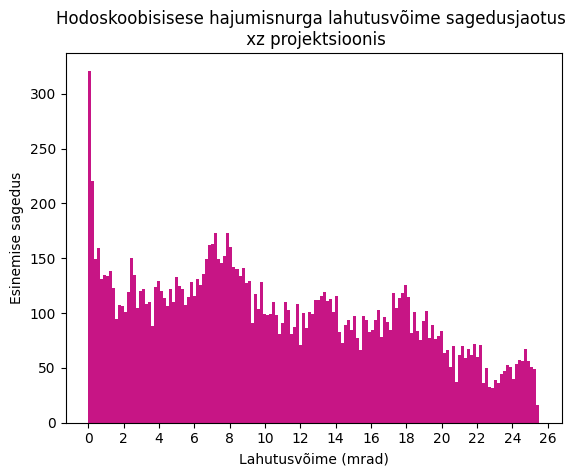

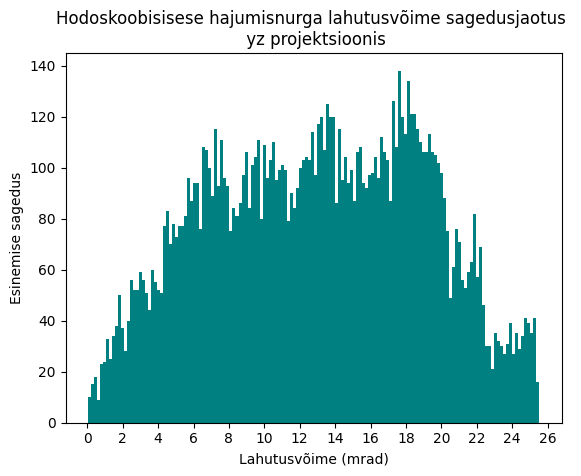

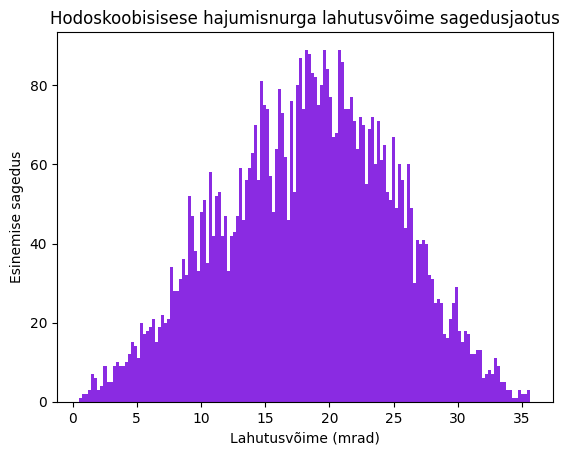

5862


In [37]:
plt.hist(hodo_angle_val_x, bins = 150,color='mediumvioletred')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n xz projektsioonis")

plt.xticks(range(0, 27, 2))
plt.show()

plt.hist(hodo_angle_val_y, bins = 150,color='teal')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus \n yz projektsioonis")

plt.xticks(range(0, 27, 2))
plt.show()


# plt.plot(hodo_vert3d,hodo_angle_val_3d, 'blueviolet',marker='.',linestyle='', markersize=2)
# plt.xlabel('Langemisnurga absoluutväärtus')
# plt.ylabel('Nurgalahutus')
# plt.title('Hodoskoobi nurgalahutus Langemisnurga sõltuvusest yz proj')
# plt.grid(True)
# plt.show()

plt.hist(hodo_angle_val_3d, bins = 150,color='blueviolet')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mrad)")
plt.title("Hodoskoobisisese hajumisnurga lahutusvõime sagedusjaotus")

plt.show()
print(len(hodo_angle_val_3d))

In [31]:
# all mats together by x or y projection
vert_x=[[],[],[]]
vert_y=[[],[],[]]
pos_res_x=[[],[],[]]
pos_res_y=[[],[],[]]
pos_res_3d=[[],[],[]]
pos_vert_3d=[[],[],[]]
# vert_x=[]
# vert_y=[]
# pos_res_x=[]
# pos_res_y=[]
for index, value in event_points_all_df['position resolution'].items():
    x=[value[0],value[2],value[4]]
    y=[value[1],value[3],value[5]]
    for ind, (xi, yi) in enumerate(zip(x, y)):
        if not np.isnan(xi) and xi<1.2:
            pos_res_x[ind].append(xi)
            vert_x[ind].append(abs(event_points_all_df['vert3_o_2Dx'][index]))
        if not np.isnan(yi) and yi<1.2:
            pos_res_y[ind].append(yi)
            vert_y[ind].append(abs(event_points_all_df['vert3_o_2Dy'][index]))
        if not np.isnan(xi) and not np.isnan(yi):
            rectangle=xi*yi
            pos_res_3d[ind].append(rectangle)
            pos_vert_3d[ind].append(event_points_all_df['position resolution'][index])

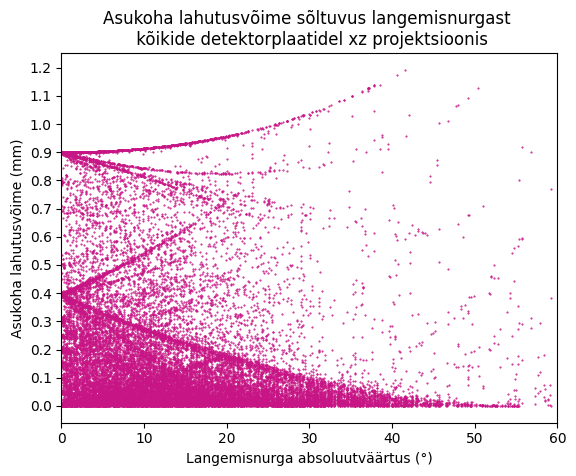

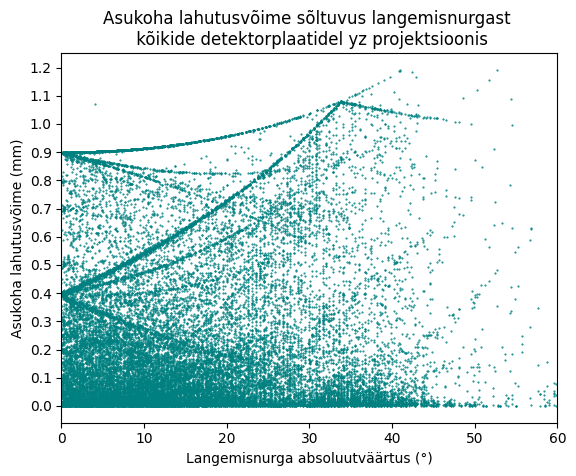

27038 30105


In [40]:
lenn_x=0
for i in [0,1,2]:
    plt.plot(vert_x[i],pos_res_x[i],color='mediumvioletred',marker='.',linestyle='', markersize=1)
    plt.xlabel('Langemisnurga absoluutväärtus (°)')
    plt.ylabel('Asukoha lahutusvõime (mm)')
    plt.title('Asukoha lahutusvõime sõltuvus langemisnurgast \n kõikide detektorplaatidel xz projektsioonis')
    plt.grid(False)
    lenn_x+=len(pos_res_x[i])
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xlim(0,60)
plt.show()
lenn_y=0
for i in range(len(vert_y)):
    plt.plot(vert_y[i],pos_res_y[i], 'teal',marker='.',linestyle='', markersize=1)
    plt.xlabel('Langemisnurga absoluutväärtus (°)')
    plt.ylabel('Asukoha lahutusvõime (mm)')
    plt.title('Asukoha lahutusvõime sõltuvus langemisnurgast \n kõikide detektorplaatidel yz projektsioonis')
    plt.grid(False)
    lenn_y+=len(pos_res_y[i])
plt.xlim(0,60)
plt.yticks(np.arange(0, 1.3, 0.1))
plt.show()
print(lenn_x,lenn_y)


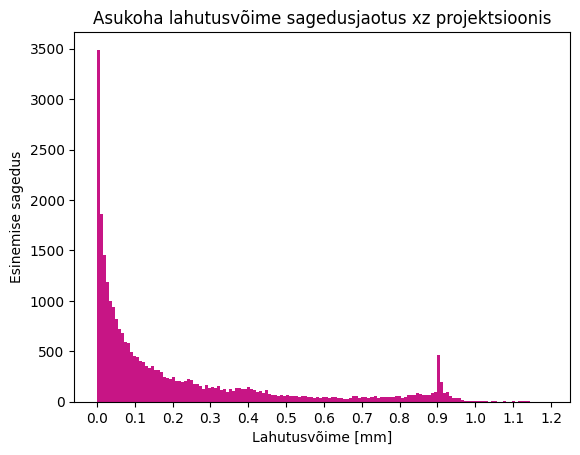

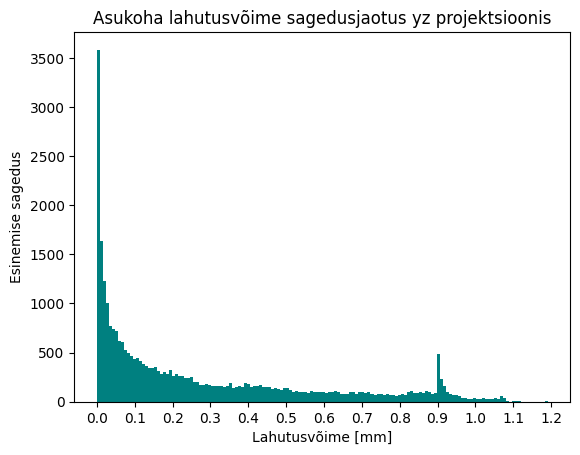

In [12]:
pos_res_x_all=np.concatenate(pos_res_x)
plt.hist(pos_res_x_all, bins = 150, color='mediumvioletred')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime [mm]")
plt.title("Asukoha lahutusvõime sagedusjaotus xz projektsioonis")
plt.xticks(np.arange(0, 1.3, 0.1))
plt.show()

pos_res_y_all=np.concatenate(pos_res_y)
plt.hist(pos_res_y_all, bins = 150, color='teal')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime [mm]")
plt.title("Asukoha lahutusvõime sagedusjaotus yz projektsioonis")
plt.xticks(np.arange(0, 1.3, 0.1))
plt.show()


10959


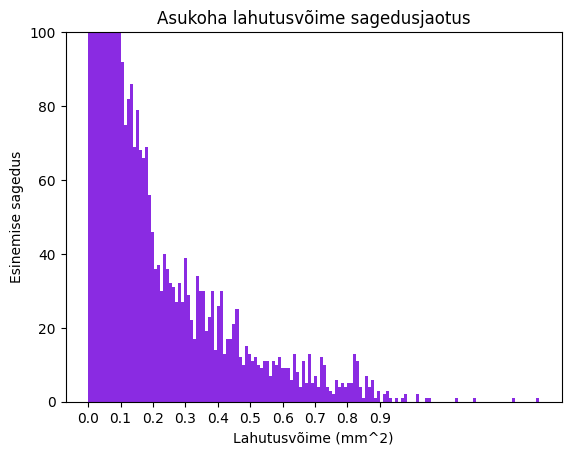

In [26]:
# for i in range(len(vert_y)):
#     plt.plot(pos_vert_3d[i],pos_res_3d[i], 'blue',marker='.',linestyle='', markersize=1)
#     plt.xlabel('Langemisnurga absoluutväärtus (°)')
#     plt.ylabel('Asukoha lahutusvõime (mm)')
#     plt.title('Asukoha lahutusvõime sõltuvus langemisnurgast \n kõikide detektorplaatidel yz projektsioonis')
#     plt.grid(True)
# plt.show()

#pos_res_3d=np.concatenate(pos_res_3d)
print(len(pos_res_3d))
plt.hist(pos_res_3d, bins = 150, color='blueviolet')
plt.ylabel("Esinemise sagedus")
plt.xlabel("Lahutusvõime (mm^2)")
plt.title("Asukoha lahutusvõime sagedusjaotus")
plt.xticks(np.arange(0, 1, 0.1))
plt.ylim(0,100)
plt.grid(False)
plt.show()

9004
9018
9016


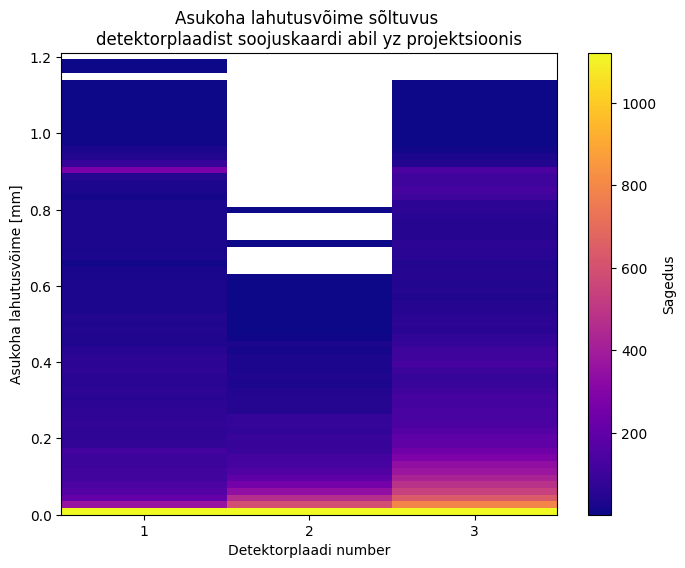

In [28]:
# Determine the bins for the histograms
all_data = np.concatenate(pos_res_y)
bins = np.linspace(all_data.min(), all_data.max()+0.02, 70)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histograms with heatmap effect
for i, values in enumerate(pos_res_x):
    num_fibers = i + 1  # Calculate the number of fibers
    
    # Create a histogram
    counts, edges = np.histogram(values, bins=bins)
    
    # Create the bar positions
    centers = (edges[:-1] + edges[1:]) / 2
    
    # Plot the histogram bars
    bar_width = (edges[1] - edges[0]) * 0
    ax.bar(centers, counts, width=0, color='white', alpha=0.5, label=f'{num_fibers} fibers')
    
    # Plot the heatmap
    x = np.full_like(values, num_fibers)
    heatmap = ax.hist2d(x, values, bins=[np.arange(1, len(pos_res_x) + 2) - 0.5, bins], cmap='plasma', cmin=1)
    print(len(values))

# Customize the plot
ax.set_xlabel('Detektorplaadi number')
ax.set_ylabel('Asukoha lahutusvõime [mm]')
ax.set_xticks(np.arange(1, len(pos_res_x) + 1))
ax.set_xticklabels([f'{i+1}' for i in range(len(pos_res_x))])
#ax.legend()

plt.colorbar(heatmap[3], ax=ax, label='Sagedus')
plt.title("Asukoha lahutusvõime sõltuvus \ndetektorplaadist soojuskaardi abil yz projektsioonis")
plt.show()